**Background:**
Predicting bankruptcy can give important insights into the stock price movement and help us take directional bets. In this ML notebook we utilize different financial ratios to predict the probability of bankruptcy

- This notebook contains data preperation, EDA, feature selection and model implementation

# Import modules

In [93]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import os
import math
%matplotlib inline


from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

- The below helper API is provided by Prof. Ken Perry, Machine Learning, NYU

In [2]:
## Load the bankruptcy_helper module
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

# Import bankruptcy_helper module
import bankruptcy_helper
%aimport bankruptcy_helper

helper = bankruptcy_helper.Helper()

# Get the data

This data is provided as a part of Machine Learning for Financial Engineers course, NYU

- Each example is a row of data corresponding to a single company
- There are 64 attributes, described in the section below
- The column `Bankrupt` is 1 if the company subsequently went bankrupt; 0 if it did not go bankrupt
- The column `Id` is a Company Identifier

In [104]:
# Data directory
DATA_DIR = "./Data"

if not os.path.isdir(DATA_DIR):
    DATA_DIR = "../resource/asnlib/publicdata/bankruptcy/data"

data_file = "5th_yr.csv"
data = pd.read_csv( os.path.join(DATA_DIR, "train", data_file) )

target_attr = "Bankrupt"

n_samples, n_attrs = data.shape
print("Date shape: ", data.shape)

Date shape:  (4818, 66)


- Let's look at the data to get a better idea

In [105]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,Id
0,0.025417,0.41769,0.0568,1.1605,-126.39,0.41355,0.025417,1.2395,1.16500,0.51773,...,0.049094,0.85835,0.12322,5.6167,7.4042,164.310,2.2214,1.334,0,4510
1,-0.023834,0.2101,0.50839,4.2374,22.034,0.058412,-0.027621,3.6579,0.98183,0.76855,...,-0.031011,1.01850,0.069047,5.7996,7.7529,26.446,13.802,6.4782,0,3537
2,0.030515,0.44606,0.19569,1.565,35.766,0.28196,0.039264,0.88456,1.05260,0.39457,...,0.077337,0.95006,0.25266,15.049,2.8179,104.730,3.4852,2.6361,0,3920
3,0.052318,0.056366,0.54562,10.68,438.2,0.13649,0.058164,10.853,1.02790,0.61173,...,0.085524,0.97282,0,6.0157,7.4626,48.756,7.4863,1.0602,0,1806
4,0.000992,0.49712,0.12316,1.3036,-71.398,0,0.001007,1.0116,1.29210,0.50288,...,0.001974,0.99925,0.019736,3.4819,8.582,114.580,3.1854,2.742,0,1529


The below is a description of all the features. We will use feature selection techniques to identify significant variables for our classification problem

# Data Preperation

- Before we proceed with any data preprocessing, lets split the test and train sets. This avoids data leak in traing our model
- Also lets shuffle the data to avoid any bias from pre-existing sorting

In [106]:
#shuffling the data
data = sklearn.utils.shuffle(data, random_state=50)

#Labels data
y = data["Bankrupt"]
X = data.drop(columns=["Bankrupt","Id"])
print("Shape of Labels : ", y.shape)
print("Shape of features : ", X.shape)

Shape of Labels :  (4818,)
Shape of features :  (4818, 64)


- Performing Train and Test split

In [107]:
X_train = None
X_test = None
y_train = None
y_test = None
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state = 42)

print("Shape of Labels_test : ", y_test.shape)
print("Shape of features_test : ", X_test.shape)
print("Shape of Labels_train : ", y_train.shape)
print("Shape of features_train : ", X_train.shape)

Shape of Labels_test :  (482,)
Shape of features_test :  (482, 64)
Shape of Labels_train :  (4336,)
Shape of features_train :  (4336, 64)


- Let's take a look at the data type of our features

In [108]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4818 entries, 118 to 1931
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4818 non-null   object 
 1   X2        4818 non-null   object 
 2   X3        4818 non-null   object 
 3   X4        4818 non-null   object 
 4   X5        4818 non-null   object 
 5   X6        4818 non-null   object 
 6   X7        4818 non-null   object 
 7   X8        4818 non-null   object 
 8   X9        4818 non-null   float64
 9   X10       4818 non-null   object 
 10  X11       4818 non-null   object 
 11  X12       4818 non-null   object 
 12  X13       4818 non-null   float64
 13  X14       4818 non-null   object 
 14  X15       4818 non-null   object 
 15  X16       4818 non-null   object 
 16  X17       4818 non-null   object 
 17  X18       4818 non-null   object 
 18  X19       4818 non-null   float64
 19  X20       4818 non-null   float64
 20  X21       4818 non-null   ob

## Converting Data to numeric values
- As seen before, the data provided contains many columns with data-type object instead of numeric type
- We will use pandas to_numeric function to convert them into numeric data
- The errors = "coerce" attribute populates a NaN value if the conversion fails. We will check and rectify this in the following section.
- We are simulatneously transforming the test data set, but it was never used for Analysis (No cheating)

In [109]:
##creating an empty data frame
data_num = pd.DataFrame() 
##passing each column in data to convert it into numeric type
for i in X_train.columns:
    data_num[i] = pd.to_numeric(X_train[i], errors = "coerce")
    
##correcting test data set for future use
X_test_new = pd.DataFrame()
for i in X_test.columns:
    X_test_new[i] = pd.to_numeric(X_test[i], errors = "coerce")

In [110]:
data_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4336 entries, 153 to 2308
Data columns (total 64 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      4334 non-null   float64
 1   X2      4334 non-null   float64
 2   X3      4334 non-null   float64
 3   X4      4325 non-null   float64
 4   X5      4326 non-null   float64
 5   X6      4334 non-null   float64
 6   X7      4334 non-null   float64
 7   X8      4326 non-null   float64
 8   X9      4336 non-null   float64
 9   X10     4334 non-null   float64
 10  X11     4334 non-null   float64
 11  X12     4325 non-null   float64
 12  X13     4336 non-null   float64
 13  X14     4334 non-null   float64
 14  X15     4331 non-null   float64
 15  X16     4326 non-null   float64
 16  X17     4326 non-null   float64
 17  X18     4334 non-null   float64
 18  X19     4336 non-null   float64
 19  X20     4336 non-null   float64
 20  X21     4270 non-null   float64
 21  X22     4334 non-null   float64
 22

- Now we can see that all the data numeric values. But now we have a lot of Null Values
- The column X37 has been seriously impacted. So lets look at what this column denotes

In [111]:
print("The number of NaN values in X37 : ", data_num[data_num["X37"].isnull()].shape[0])

The number of NaN values in X37 :  1850


In [112]:
print("Number of bankruptcy examples with null X37 values", data_num[(data_num["X37"].isnull()) & (y_train==1)].shape[0])

Number of bankruptcy examples with null X37 values 142


- We have only 308 examples with bankruptcy. So it might not be wise to remove all the examples with NaN values for X37, as we might loose around half of the class 1 examples.
- X37 denotes the ratio (current assets - inventories) / long-term liabilities. All these terms appear in other features. Considering the presences of non-indepence , may be it's okay to drop this column

## Dealing with missing values
- In this section, we drop the column X37 and remaining NA values

In [113]:
#dropping X37
data_num = data_num.drop(columns = ["X37"])
data_num.shape
#dropping X37 from test features to be consistent
X_test = X_test_new.drop(columns = ["X37"])

(4336, 63)

- For the remaining NaN values, we can employ the same method. But the problem is, these NaN values are mostly associated with Class 1 examples. When we remove Na values using dropna command, our class1 size reduces significantly
- So let's use imputation to avoid this problem

In [114]:
print("No. of Bankruptcy cases - Class 1: ",y_train.sum())
print("No. of Bankruptcy cases - Class 0: ",y_train.shape[0]- y_train.sum())

No. of Bankruptcy cases - Class 1:  276
No. of Bankruptcy cases - Class 0:  4060


- We can use a simple imputer and fill the NaN values using mean/median/mode. But this might distort the histogram of our features
- Here we try to impute using the KNN imputer algorithm, which works similar to the KNN algorithm. This might be a good solution to our problem as we are looking for similar values and filling the NA values
- before impuation - No X37 and ID columns

In [115]:
#imputing train data
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
data_num = pd.DataFrame(imputer.fit_transform(data_num),columns = data_num.columns)
data_num.info()

#imputing test data. We are using the same imputer to transform test data
X_test = pd.DataFrame(imputer.transform(X_test),columns = X_test.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4336 entries, 0 to 4335
Data columns (total 63 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      4336 non-null   float64
 1   X2      4336 non-null   float64
 2   X3      4336 non-null   float64
 3   X4      4336 non-null   float64
 4   X5      4336 non-null   float64
 5   X6      4336 non-null   float64
 6   X7      4336 non-null   float64
 7   X8      4336 non-null   float64
 8   X9      4336 non-null   float64
 9   X10     4336 non-null   float64
 10  X11     4336 non-null   float64
 11  X12     4336 non-null   float64
 12  X13     4336 non-null   float64
 13  X14     4336 non-null   float64
 14  X15     4336 non-null   float64
 15  X16     4336 non-null   float64
 16  X17     4336 non-null   float64
 17  X18     4336 non-null   float64
 18  X19     4336 non-null   float64
 19  X20     4336 non-null   float64
 20  X21     4336 non-null   float64
 21  X22     4336 non-null   float64
 22  

- Now we do not have any missing values in our data. 

## Dealing with class imbalance
- As we saw before there is a significant class imbalance. Due to this our model will not be able to effectively learn the characteristics of the minority
- The below bar plot reiterates this problem

Text(0.5, 0, 'Class')

Text(0, 0.5, 'Class Counts')

Text(0.5, 1.0, 'Class Distribution before imbalance correction')

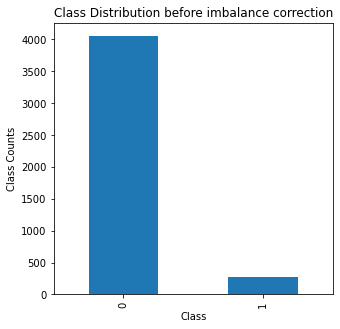

In [116]:
plt.rcParams['figure.figsize'] = [5, 5]
y_train.value_counts().plot.bar()
plt.xlabel("Class")
plt.ylabel("Class Counts")
plt.title("Class Distribution before imbalance correction")

- In order to correct this we employ SMOTE technique from SKlearn. 
- Ideally we can perform simple oversampling or undersampling. But undersampling eliminates valuable data which can be used by our model and oversampling might cause the problem of overfitting
- Hence we employ the method of synthetically creating minority class samples. SMOTE is a popular technique for that.

In [117]:
#saving unbalanced dataset for future use | we use deep copy here
data_num_unb = data_num.copy(deep=True)
y_train_unb = y_train.copy(deep=True)

In [118]:
SM = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
data_num, y_train = SM.fit_resample(data_num, y_train)

Text(0.5, 0, 'Class')

Text(0, 0.5, 'Class Counts')

Text(0.5, 1.0, 'Class Distribution after SMOTE')

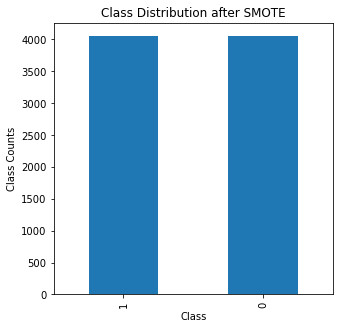

In [119]:
plt.rcParams['figure.figsize'] = [5, 5]
y_train.value_counts().plot.bar()
plt.xlabel("Class")
plt.ylabel("Class Counts")
plt.title("Class Distribution after SMOTE")

- Now we have equal representation from both classes

- Considering the lower precision from our models in sections 6.6,6.7 I am trying a differet resampling technique adasyn
- Considering Adasyn introduces randomness after performing the over sampling, data might be realistic

In [120]:
ad = ADASYN(random_state=42)
data_num_ad, y_train_ad = ad.fit_resample(data_num_unb, y_train_unb)

Text(0.5, 0, 'Class')

Text(0, 0.5, 'Class Counts')

Text(0.5, 1.0, 'Class Distribution after ADASYN')

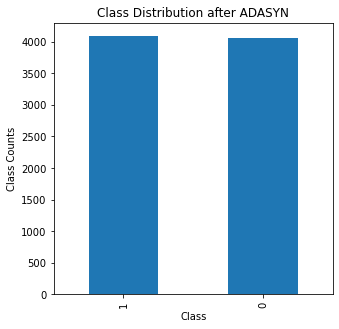

In [121]:
plt.rcParams['figure.figsize'] = [5, 5]
y_train_ad.value_counts().plot.bar()
plt.xlabel("Class")
plt.ylabel("Class Counts")
plt.title("Class Distribution after ADASYN")

# Exploratory Data Analysis
- Given the high dimensionality of our data set, it is difficult to visualize the features 
- Here we construct a pivot table with mean as the aggregating function to check for distinguishing characters between class-0 and class-1 examples

In [26]:
data_num.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64
0,0.034528,0.30035,0.204410,1.77250,25.9680,-0.19624,0.034528,2.32940,1.4943,0.69965,...,63.489,0.037867,0.04935,0.97694,0.00000,14.5910,4.6122,64.634,5.6472,2.8143
1,0.060186,0.63270,0.092142,1.15640,-123.7500,0.17648,0.072793,0.58052,1.0788,0.36730,...,15086.000,0.073016,0.16386,0.92698,0.11885,2.8150,13.0160,142.070,2.5691,4.7468
2,-0.056756,0.80413,0.066074,1.08220,-41.1000,-0.06441,-0.046925,0.16731,1.0007,0.13454,...,1148.000,0.000656,-0.42184,0.99934,0.00000,7.0622,4.7799,132.220,2.7605,17.1010
3,0.152950,0.86722,0.364170,1.69340,-8.9739,0.00000,0.152950,0.15312,2.7425,0.13278,...,1022.200,0.023209,1.15190,0.94790,2.57560,6.5051,6.3195,69.900,5.2217,24.7940
4,0.126900,0.60746,-0.126100,0.79241,-46.6500,0.26527,0.159650,0.58595,1.0713,0.35594,...,-30721.000,0.066537,0.35651,0.93346,0.00000,12.6900,14.0290,69.478,5.2534,6.1532


In [122]:
#combining data frame with target for easier analysis. This data set will not be used for training
data_combine = data_num.copy(deep=True)
data_combine["Bankrupt"] = y_train

In [123]:
table = pd.pivot_table(data_combine, values = data_combine.columns, index=["Bankrupt"],aggfunc={np.median})
table

,X1,X10,X11,X12,X13,X14,X15,X16,X17,X18,...,X59,X6,X60,X61,X62,X63,X64,X7,X8,X9
,median,median,median,median,median,median,median,median,median,median,...,median,median,median,median,median,median,median,median,median,median
Bankrupt,,,,,,,,,,,,,,,,,,,,,
0,0.051543,0.537090,0.075630,0.189120,0.070985,0.06240,944.050000,0.258425,2.293450,0.06240,...,0.007740,0.000000,9.379800,6.088150,72.215000,5.051400,4.224000,0.062341,1.223700,1.137800
1,-0.062497,0.251329,-0.045634,-0.116088,-0.018966,-0.06232,-520.313295,-0.037031,1.411659,-0.06232,...,0.025511,-0.073495,10.890284,8.355602,132.547573,3.043532,5.467625,-0.062320,0.387783,1.398913


<Figure size 2160x2160 with 0 Axes>

Text(0.5, 0, 'Features')

Text(0, 0.5, 'Median Value')

Text(0.5, 1.0, 'Feature Median value comparision')

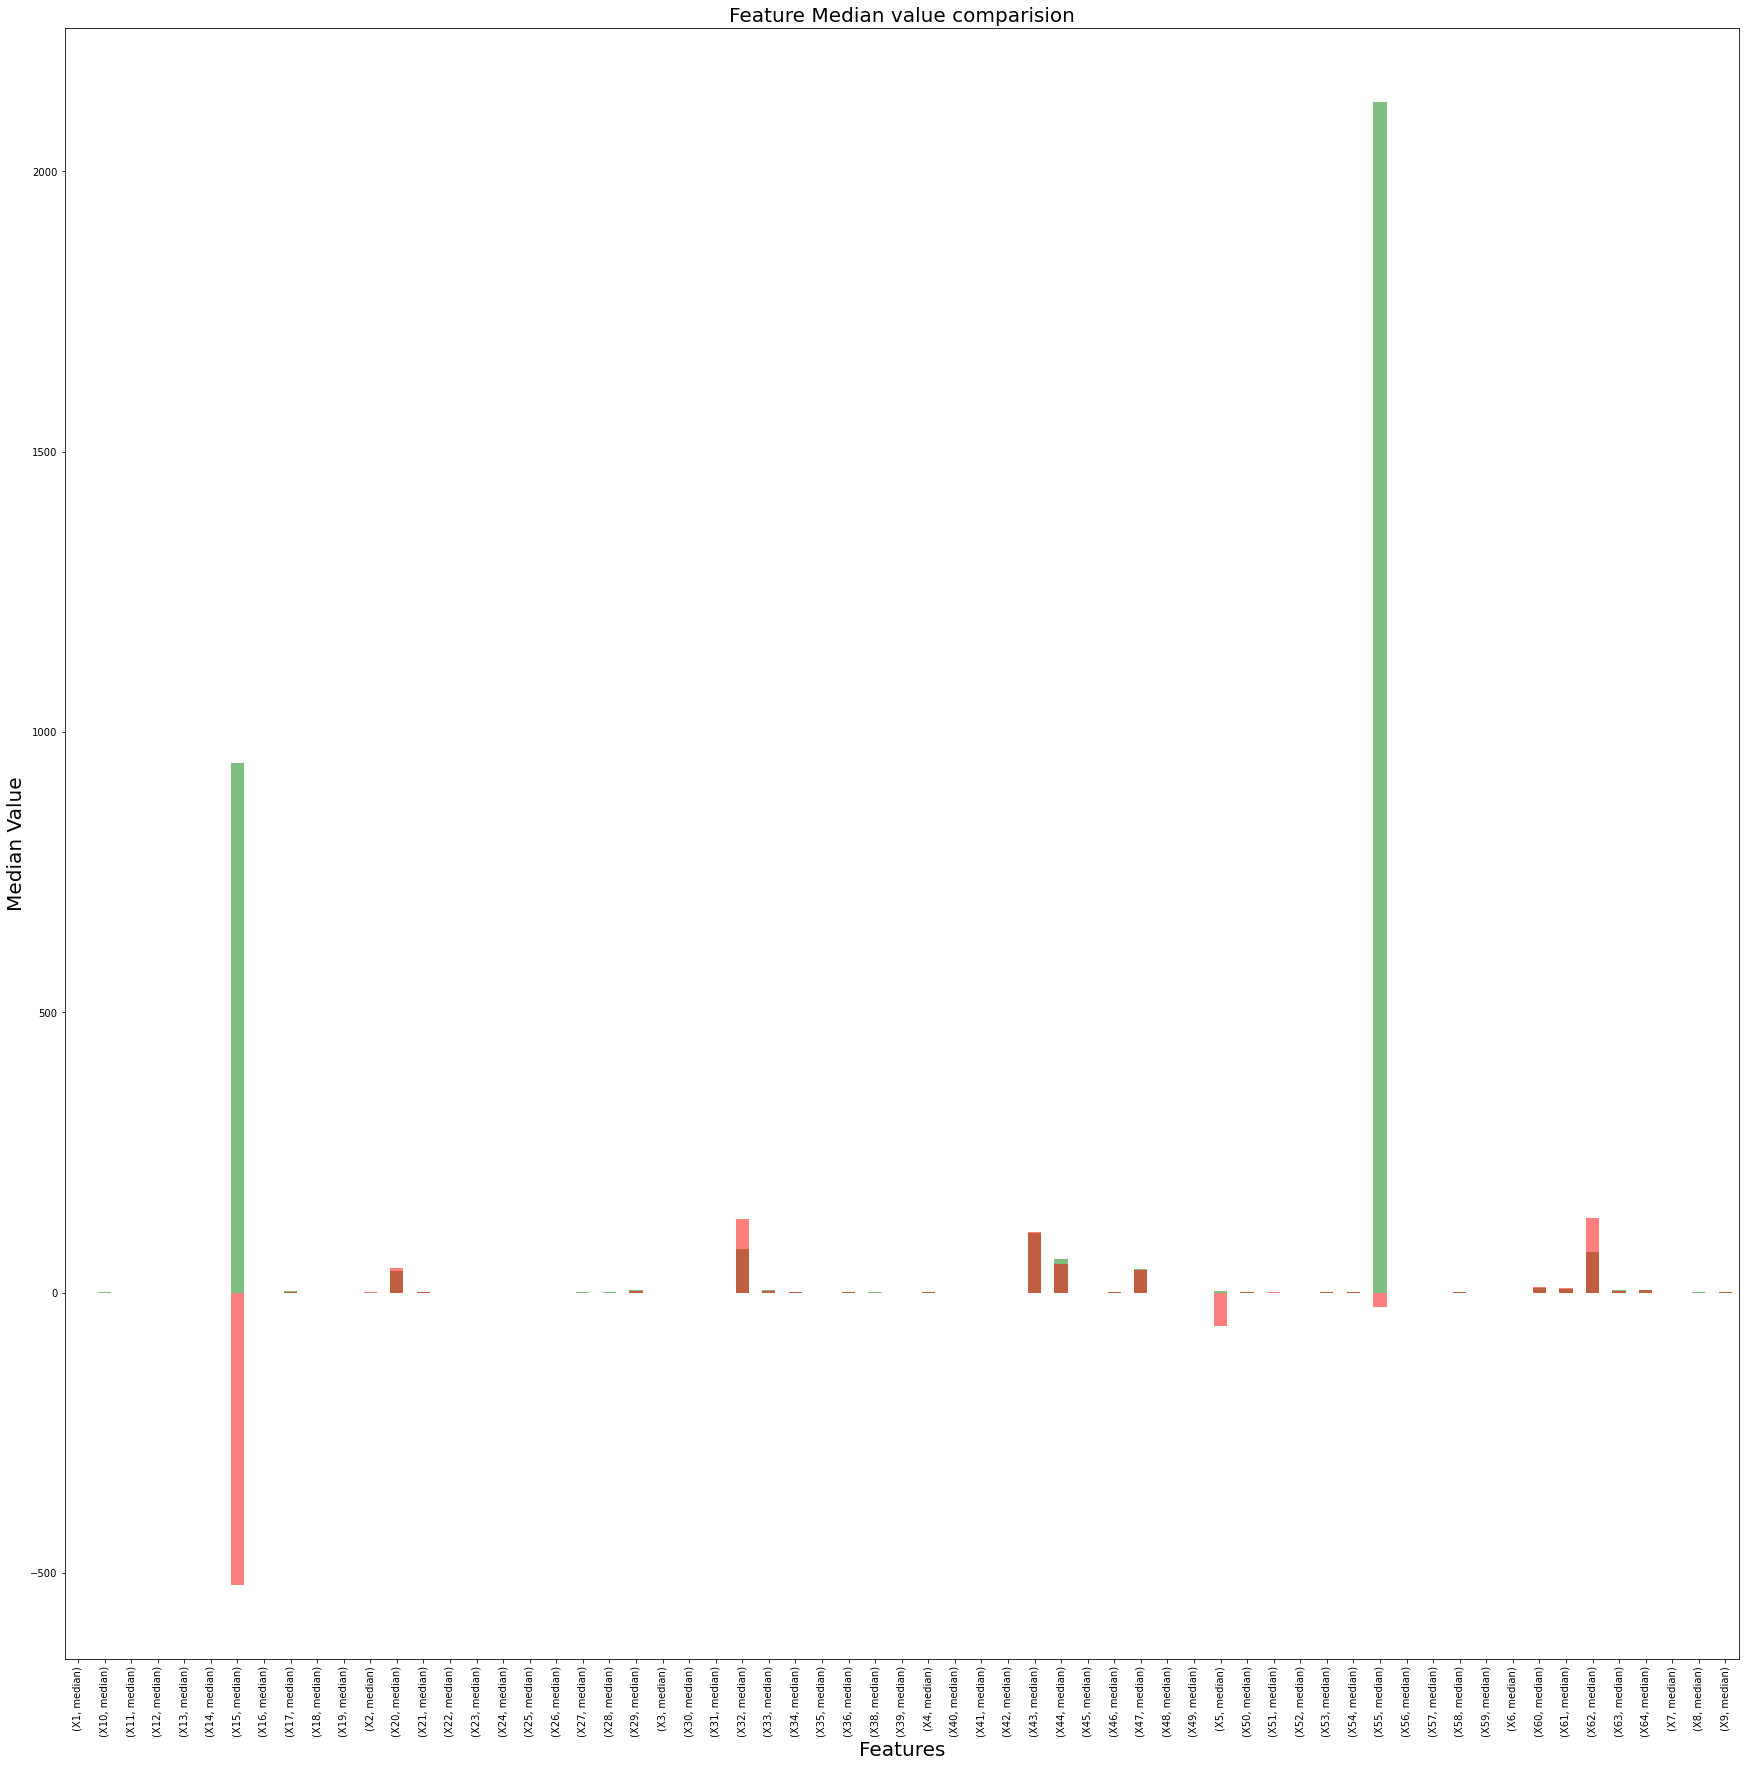

In [129]:
plt.figure(figsize=(30,30))
table.iloc[0,:].plot(kind ="bar", color ="g", alpha = 0.5)
table.iloc[1,:].plot(kind ="bar",color="r", alpha = 0.5)
plt.xlabel("Features",fontsize=20)
plt.ylabel("Median Value",fontsize=20)
plt.title("Feature Median value comparision",fontsize=20)

- Our pivot table is calculating the median values across different features
- Looking at the above graph, we can identify that class1 and class0 cases differ significantly on few factors.
- Few cases are X15 ((total liabilities * 365) / (gross profit + depreciation)), X32 ((current liabilities * 365) / cost of products sold), X55 (working capital)
- Working capital (X55) is important for the day to day functioning of the business. So it is expected for the class 0 examples to have higher working capital when compared to class 1 examples






# Feature selection
- In our problem we 64 features (high-dimensional data)
- In this section, we try to explore some techniques to select the most important features for the classification problem

## Mutual information classification technique
- In this technique we are calculating the information gain from the features and selecting the ones with high values
- We utilize sklearn feature selection module for this selection
- We also plan to remove the id column, as we know it is just a record keeping number

<Figure size 3600x3600 with 0 Axes>

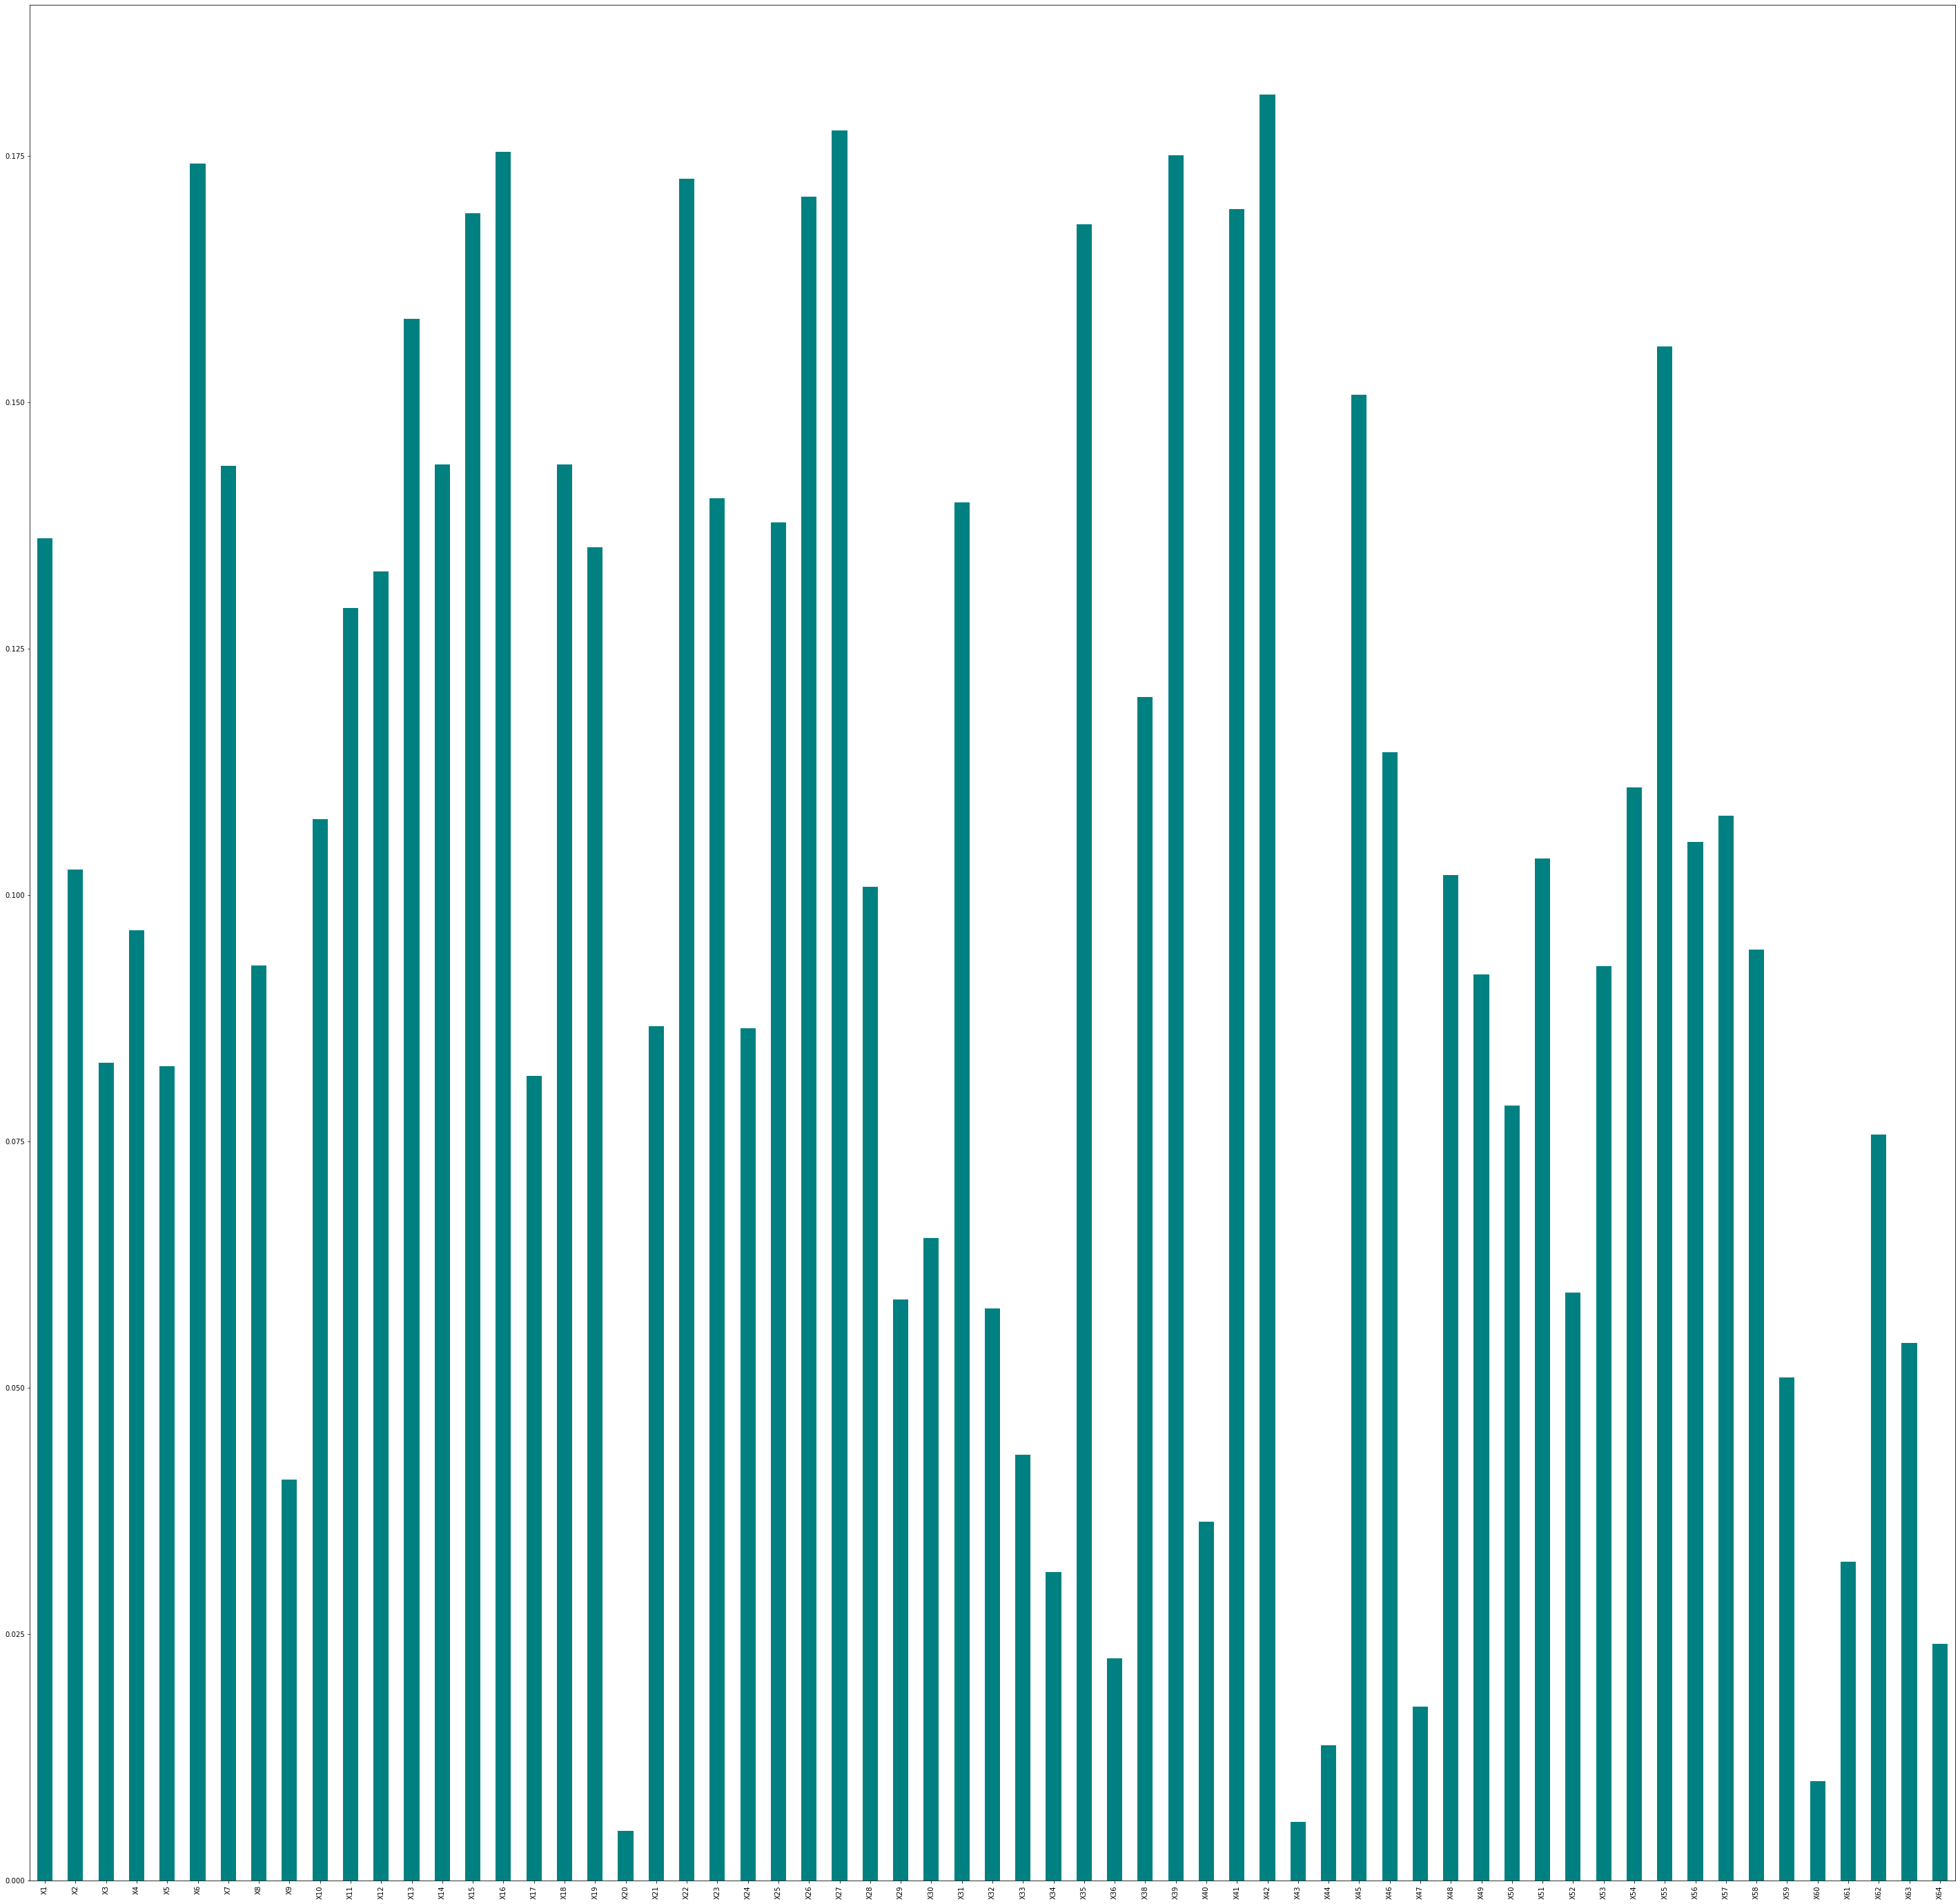

In [30]:
plt.figure(figsize=(50,50))

from sklearn.feature_selection import mutual_info_classif
ig_ranks = mutual_info_classif(data_num,y_train)
ig_ranks_series = pd.Series(ig_ranks,data_num.columns)
ig_ranks_series.plot(kind="bar",color="teal")

plt.show()

In [130]:
#creating a data frame for the Information gain scores
ig_ranks_df = pd.DataFrame(ig_ranks_series.sort_values(ascending = False),columns = ["Score"])

ig_ranks_df.head(30)

,Score
X42,0.181256
X27,0.177564
X16,0.175441
X39,0.175060
X6,0.174247
X22,0.172699
X26,0.170832
X41,0.169600
X15,0.169169
X35,0.168081


- The above are the top 30 features based on information gain. X27 (profit on operating activities / financial expenses) , X22 (profit on operating activities / total assets) , X42 (profit on operating activities / sales) are the top features
- We can see an interesting pattern here. All the of these three features contain profit on operating activities as the numerator. So this value might be important for deciding the porbability of bankruptcy
- Lets try few other techniques

## Checking correlation
- Now lets try to see the correlation amongst different variables. This helps us identify not only the imporatance features but also identify multi-colinearity amongst the features


<Figure size 2880x2880 with 0 Axes>

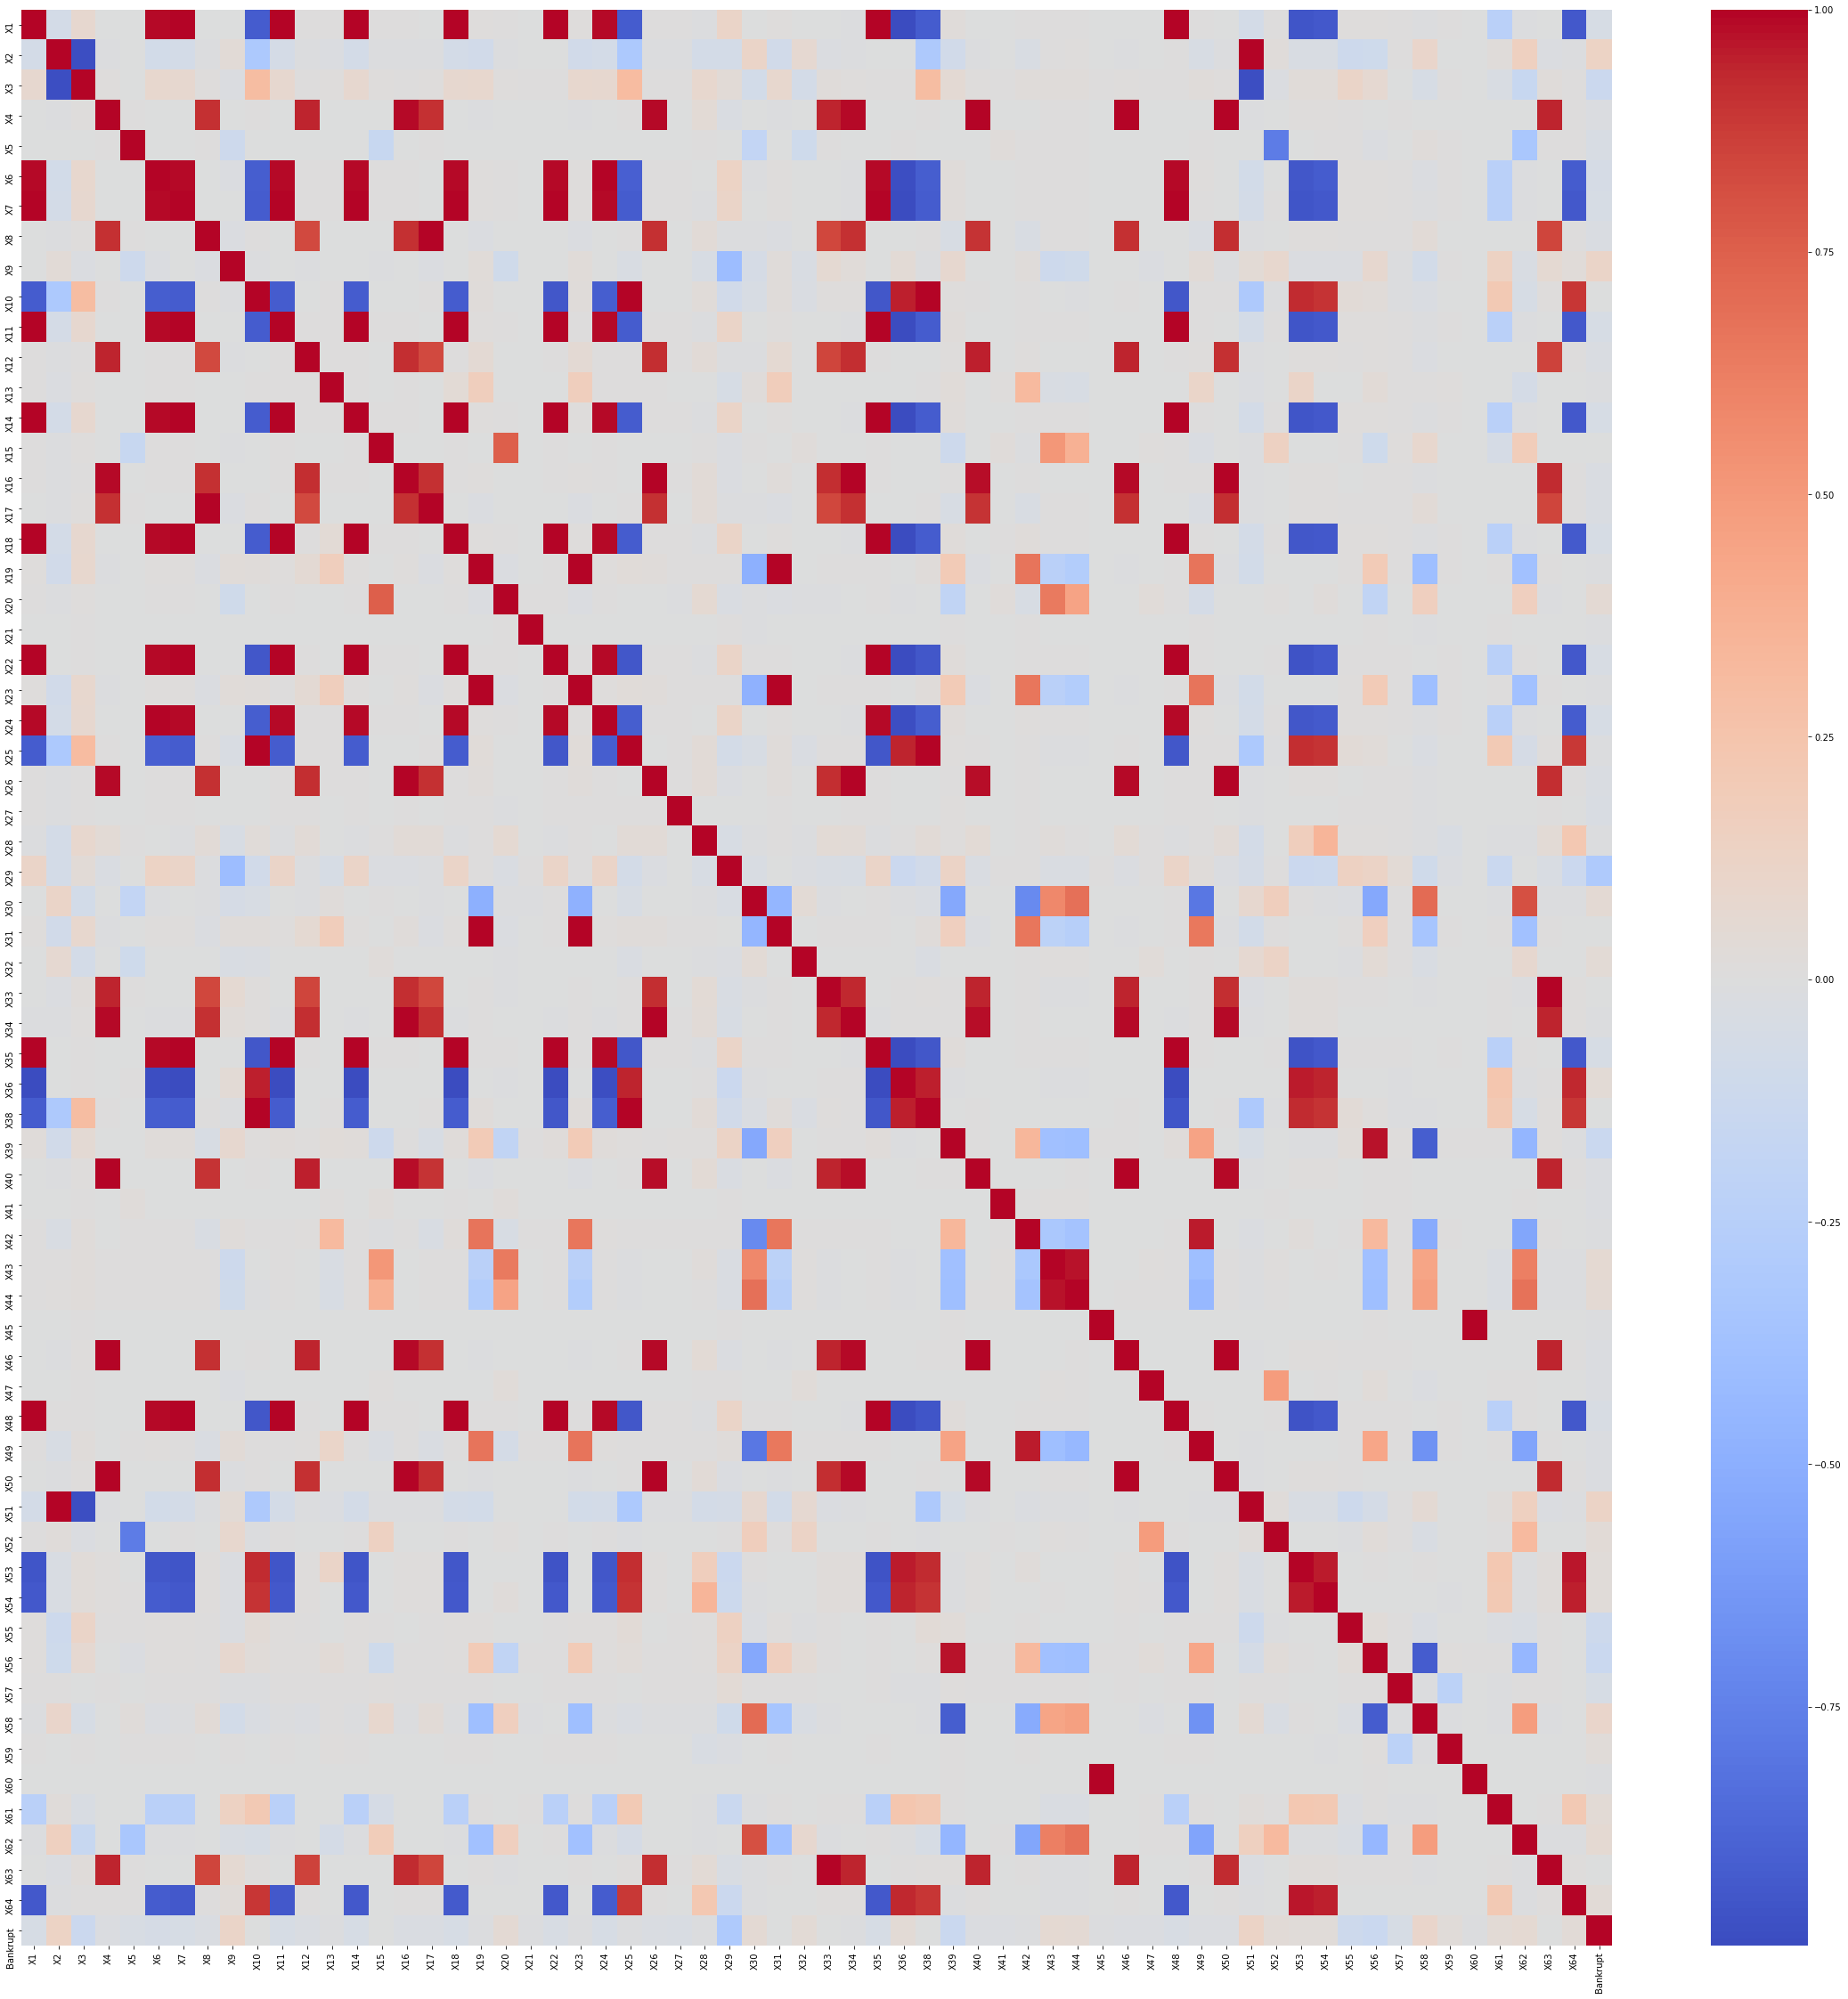

In [33]:
import seaborn as sns
from seaborn import heatmap

plt.figure(figsize=(40,40))
corr = data_combine.corr()
heatmap(corr, cmap = 'coolwarm')
plt.show()

- From the above heatmap we can see that there are no features that are strongly correlated with bankruptcy.
- The pearson correlation statastic is looking for a linear relationship. Our target variable seemed to be uncorrelated probably due to non-linearity in the data
- Another thing to notice is the high correlations between some of the features. This gives us the evidence of multi-colinearity. We will try this adress this in the coming sections

In [34]:
#creating a correlation df for the target. This will be used later for selecting features for our classification models
corr_bankrupt = corr["Bankrupt"].copy(deep = True)
corr_bankrupt.transpose

<bound method IndexOpsMixin.transpose of X1         -0.048416
X2          0.128660
X3         -0.124391
X4         -0.018840
X5         -0.040440
              ...   
X61         0.047501
X62         0.060900
X63        -0.005842
X64         0.033593
Bankrupt    1.000000
Name: Bankrupt, Length: 64, dtype: float64>

In [35]:
corr_bankrupt = np.absolute(corr_bankrupt)
corr_bankrupt.sort_values(ascending = False).head(10)

Bankrupt    1.000000
X29         0.298808
X39         0.136776
X56         0.132240
X2          0.128660
X3          0.124391
X51         0.121627
X55         0.113460
X9          0.111764
X58         0.101057
Name: Bankrupt, dtype: float64

In [36]:
corr_bankrupt_df = pd.DataFrame(corr_bankrupt)
corr_bankrupt_df = corr_bankrupt_df.rename(columns={"Bankrupt":"Correlation"})

## Emebed Models
- In this section we use Machine learning Models to estimate the importance of features. We employ Lasso and Random Forests for this purpose
- With L1 regularization Lasso models sets the values of non important features to 0

### Lasso (L1)

In [131]:
from sklearn.linear_model import LogisticRegression

logist = LogisticRegression(C=1,penalty="l1",solver="liblinear",random_state=42).fit(data_num,y_train)

df_coef = pd.DataFrame(logist.coef_)

df_lasso_feat = pd.DataFrame(columns =["Features","Lasso_score"])
df_lasso_feat["Features"] = [columns for columns in data_num.columns]
df_lasso_feat["Lasso_score"] = [float(abs(df_coef[i].values)) for i in range(logist.coef_.shape[1])]
df_lasso_feat

C:\Users\Santosh\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


,Features,Lasso_score
0,X1,1.670176
1,X2,0.938575
2,X3,0.906450
3,X4,0.110597
4,X5,0.000005
...,...,...
58,X60,0.000007
59,X61,0.002456
60,X62,0.000871
61,X63,0.015150


- Some of the feature coefficients have been set 0. We can probably remove these to reduce the dimensionality in our problem

### Random Forests Importance
- Here we employ Random Forest algorithm's built-in methods to identify the important features

In [133]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=300,random_state=50)
model_rf.fit(data_num,y_train)

#getting the importance
importance_rf = model_rf.feature_importances_

#creating data frame for visualization
importance_rf_df = pd.DataFrame({"Features":pd.DataFrame(data_num).columns,"Importance":importance_rf})

RandomForestClassifier(n_estimators=300, random_state=50)

Text(0.5, 0, 'Features')

Text(0, 0.5, 'Random Forest Importances')

Text(0.5, 1.0, 'Random Forest Importance for Features')

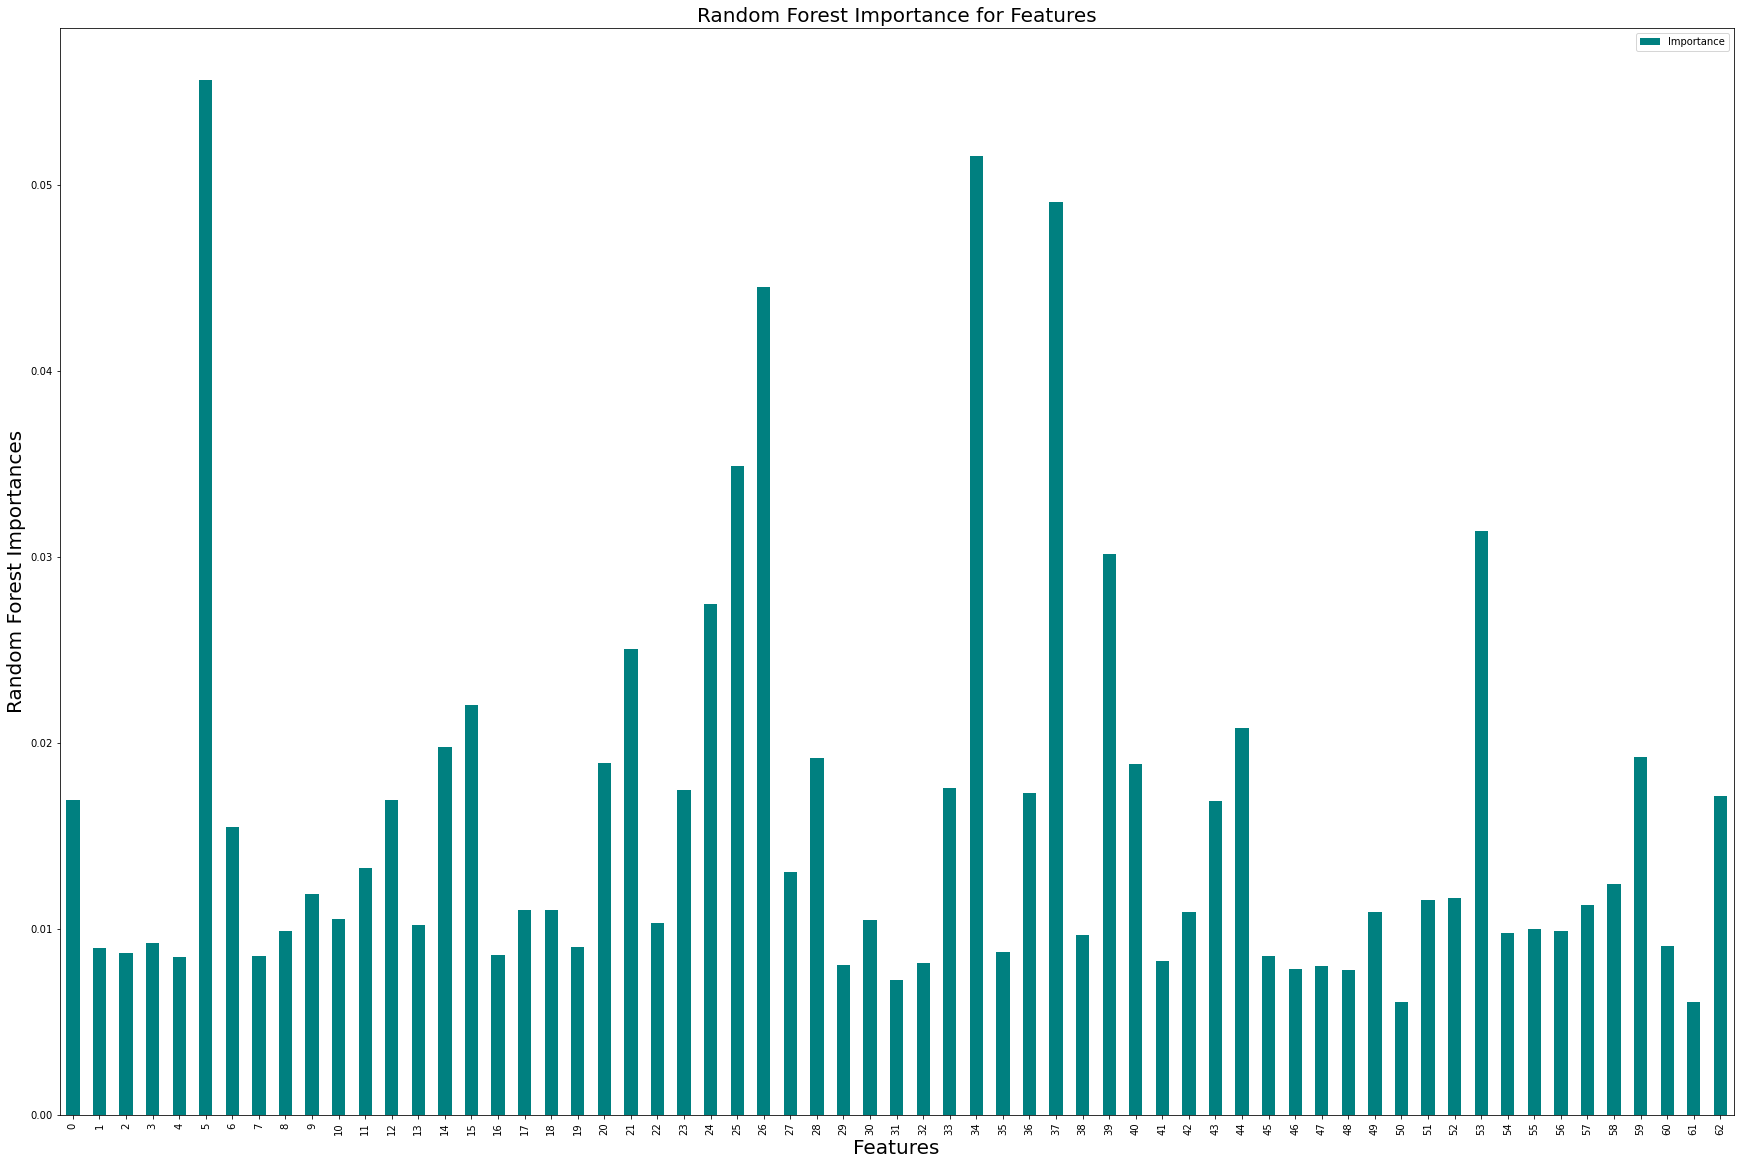

In [135]:
plt.rcParams['figure.figsize'] = [30, 20]
importance_rf_df.plot(kind = "bar", color="teal")
plt.xlabel("Features",fontsize=20)
plt.ylabel("Random Forest Importances",fontsize=20)
plt.title("Random Forest Importance for Features", fontsize=20)
plt.show()

In [136]:
importance_rf_df.sort_values("Importance",ascending = False)

,Features,Importance
5,X6,0.055665
34,X35,0.051584
37,X39,0.049095
26,X27,0.044500
25,X26,0.034891
...,...,...
46,X48,0.007873
48,X50,0.007792
31,X32,0.007273
50,X52,0.006093


- from the above dataframe we can identify the important features for this problem

## Dimensionality Reduction
- As seen from the correlation heatmap, the features in this data set are highly correlated
- This probably due to the same metrics being used in different Financial Ratios
- In this section we explore this problem more and reduce the dimensions of the dataset to fix multi-colinearity

- We employ Principal Component Analysis for dimensionality reduction
- This algorithm is sensitive to the scale of features. Hence we use a standard scaler to scale the data

In [137]:
#Scaling the data using Standard Scaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#storing the column names
cols = data_num.columns
#fit and transform
data_num = scaler.fit_transform(data_num)

data_num = pd.DataFrame(data_num, columns = cols )

data_num.head(20)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64
0,0.046569,-0.205957,0.113247,-0.026599,0.032731,0.038379,0.045923,-0.017096,-0.154410,0.028640,...,-0.067188,0.091705,0.046475,-0.069182,-0.075650,-0.012095,-0.188297,-0.107560,-0.033589,-0.066456
1,0.048448,-0.072155,0.068729,-0.034592,0.028399,0.065356,0.048724,-0.037952,-0.459034,-0.011799,...,0.173201,0.136120,0.065158,-0.117460,-0.055168,-0.012315,-0.000878,-0.070671,-0.067027,-0.064336
2,0.039885,-0.003139,0.058392,-0.035555,0.030790,0.047921,0.039959,-0.042880,-0.516293,-0.040119,...,-0.049834,0.044685,-0.030403,-0.047536,-0.075650,-0.012236,-0.184557,-0.075363,-0.064948,-0.050788
3,0.055240,0.022261,0.176596,-0.027625,0.031720,0.052583,0.054594,-0.043049,0.760708,-0.040334,...,-0.051847,0.073183,0.226362,-0.097244,0.368213,-0.012246,-0.150221,-0.105051,-0.038211,-0.042351
4,0.053333,-0.082317,-0.017811,-0.039314,0.030630,0.071783,0.055084,-0.037887,-0.464533,-0.013181,...,-0.559799,0.127933,0.096590,-0.111198,-0.075650,-0.012131,0.021714,-0.105252,-0.037867,-0.062794
5,0.050452,-0.200804,0.095300,-0.025391,0.030293,0.069611,0.049850,-0.018718,-0.325821,0.027082,...,1.353343,0.304957,0.059220,-0.246574,-0.043212,-0.012322,-0.170594,-0.082623,-0.061042,-0.068584
6,0.052671,-0.320825,0.350325,0.655911,0.043264,0.071177,0.054079,0.733067,-0.386892,0.062808,...,1.755535,0.234030,0.058036,-0.192333,-0.075650,-0.012316,-0.204058,-0.134245,0.365261,-0.065720
7,0.044280,-0.145464,-0.016360,-0.041273,0.031255,0.055268,0.043802,-0.032804,-0.516828,-0.000995,...,-0.089368,0.043819,0.039592,-0.046898,-0.034394,-0.011558,0.185565,-0.117011,-0.006417,-0.065635
8,0.046009,-0.145423,0.209433,-0.023611,0.032586,0.052583,0.045815,-0.030342,-0.040479,0.010345,...,-0.035618,0.056255,0.046407,-0.065819,-0.075650,-0.012279,-0.219426,-0.091370,-0.054730,-0.052678
9,0.045193,-0.252972,0.339725,0.018190,0.038378,0.087714,0.044887,0.004169,-0.516931,0.035369,...,0.180194,0.043646,0.041823,-0.046704,-0.075650,-0.012001,-0.128250,-0.111099,-0.025620,-0.038111


PCA(n_components=63)

Text(0.5, 0, 'number of components')

Text(0, 0.5, 'cumulative explained variance')

Text(0.5, 1.0, 'Explained Variance vs. No. of Principal components')

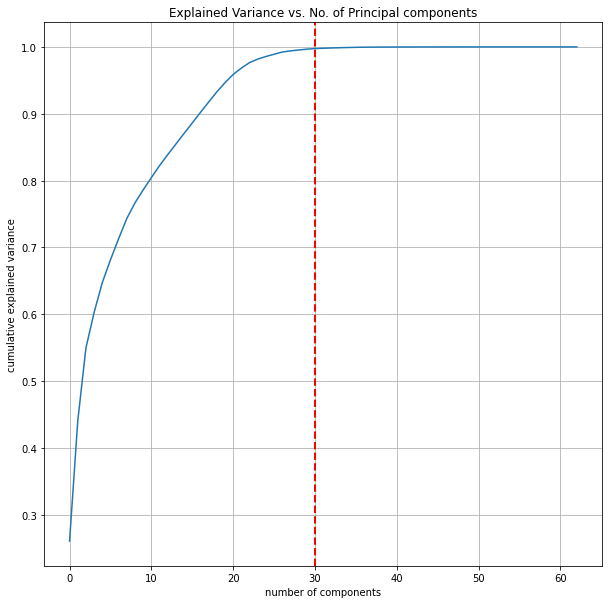

None

In [139]:
from sklearn.decomposition import PCA

#lets first check for 63 components
pca_test = PCA(n_components=63)
pca_test.fit(data_num)

#Lets plot the cumulative explained variance vs. no. components
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Explained Variance vs. No. of Principal components')
plt.grid()
plt.axvline(linewidth=2, color='r', linestyle = '--', x=30, ymin=0, ymax=1)
display(plt.show())

- From the above graph we can see that only 30 principal components are necessary for completely explaining the variance
- So we can reduce the n_components parameter to 30

# Classification Models
- In this section we try to implement different Machine Learning models and compare them based on performance statastics
- Lets first use a baseline model with out any feature selection or dimensionality reduction. We use Logistic Regression for this

## Logistic Regression

In [43]:
X_test_num = X_test

In [44]:
from sklearn.model_selection import cross_val_score

#the data here is already scaled. So need to scale it again for the model
logist_base = LogisticRegression(penalty = "l1", solver = "liblinear",random_state=42).fit(data_num,y_train)

#cross validation parameters (folds)
k = 5

#fitting the transformations and the model
cross_val_scores_base = cross_val_score(logist_base,data_num,y_train,cv=k)

print("Average Cross Val Score : ", format(cross_val_scores_base.mean()) )

#predicting test data
y_pred = logist_base.predict(X_test_num)

#Accuracy out of sample
print("Out of sample accuracy : ", logist_base.score(X_test_num,y_test))

Average Cross Val Score :  0.8022167487684729
Out of sample accuracy :  0.8402489626556017


- In our model, we used l1 regularization, which penalizes high values for coefficients. Cosidering we have a high-dimensional data set, l1 can zero out the coefficients for the redundant features.
- Our cross_val_score is good, but it does gaurantee better model performance. We need to investigate performance using other metrics like Confusion Matrix, precision and recall

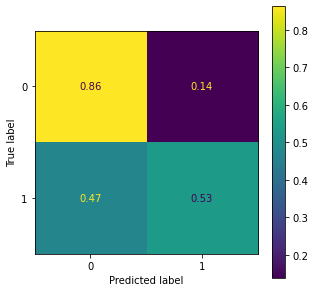

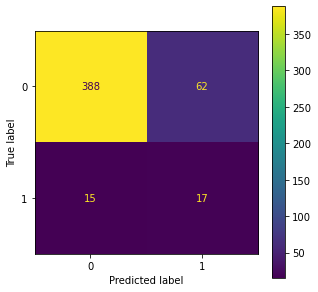

In [45]:
from sklearn.metrics import plot_confusion_matrix

#setting the plot size
plt.rcParams['figure.figsize'] = [5, 5]

#plotting the confusion matrix
plot_confusion_matrix(logist_base,X_test_num,y_test,normalize = "true")

plot_confusion_matrix(logist_base,X_test_num,y_test)


- From the above confusion_matrix we can see that class-1 suffers from significant number of mis-classifications. Class 0 predictions on the other hand seem more accurate

In [46]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print("Precision score : ",precision_score(y_test,y_pred))
print("Recall score : ",recall_score(y_test,y_pred))
print("F1 score : ",f1_score(y_test,y_pred))

Precision score :  0.21518987341772153
Recall score :  0.53125
F1 score :  0.3063063063063063


- Precision, Recall are important metrics to evaluate the performance of our model
- Looking at the scores, we can see that our model has trouble in identifying the class-1 cases
- Our aim is to acheive high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate.
- We also look at F1 score given by 2 * (precision * recall) / (precision + recall). This gives us a single metric for evaluation. Our goal is increase this value
- Now lets further explore by looking at the precision recall curve

Average precision-recall score: 0.15


Text(0.5, 1.0, '2-class Precision-Recall curve:AP=0.15')

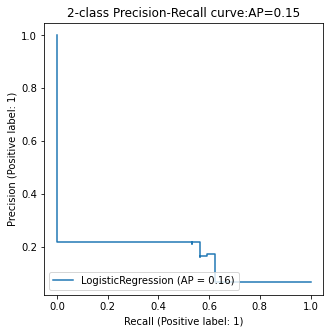

In [47]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

from sklearn.metrics import average_precision_score

average_precision = average_precision_score(y_test, y_pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

disp = plot_precision_recall_curve(logist_base, X_test_num, y_test)
disp.ax_.set_title('2-class Precision-Recall curve:''AP={0:0.2f}'.format(average_precision))


- This graph shows us the trade off between precision and recall. We want the area under to be higher, which mean high precision and high recall
- the avergae precision is 0.18. This metric is the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight

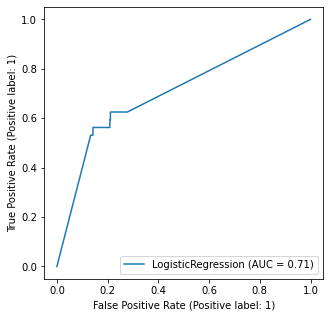

In [48]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(logist_base,X_test_num,y_test)

- AUC is a measure of our model performance. In the next sections we will try to improve the AUC, which is currently at 0.71

## Logistic Regression with PCA

- Our training feature data set data_num has to be scaled for applying PCA. This has already been done in the previous sections
- We will scale our test data before predicting the values
- In our model we are going to use 30 principal components to explain maximum variability. As seen in the Dimensionality reduction section, increasing the components to more than 30 doesn't really explain more variance

In [140]:
#scaling test data set
scaler_lr_pca = StandardScaler()

#storing the column names
cols_test = X_test_num.columns

#fit and transform
X_test_num = scaler_lr_pca.fit_transform(X_test_num)

X_test_num = pd.DataFrame(X_test_num, columns = cols_test )

X_test_num.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64
0,-1.013645,0.332283,-0.017227,-0.116747,-0.070566,-0.042776,-1.028510,-0.136804,1.887705,-0.287408,...,-0.182861,-0.486007,-0.244711,0.073063,-0.148476,-0.094470,-0.103017,-0.225876,-0.075254,-0.007791
1,-0.151853,0.025322,-0.598566,-0.134259,-0.162575,-0.042929,-0.202215,-0.124658,0.376195,0.004696,...,-0.188199,0.532474,-0.059064,-0.114103,-0.148476,-0.097953,-0.038666,-0.109897,-0.138834,-0.108829
2,1.309746,-0.278863,0.525921,-0.080796,0.173049,-0.042929,1.544754,-0.103009,0.331341,0.294157,...,-0.171845,0.609476,0.109758,-0.194623,-0.148476,0.135192,-0.256443,-0.192842,-0.098314,-0.080387
3,-0.247118,0.169709,0.293115,-0.105575,0.010125,-0.233780,-0.237430,-0.131136,0.414328,-0.132702,...,-0.159293,-0.120040,-0.074720,0.024352,-0.148476,-0.101871,-0.211105,-0.039718,-0.161621,-0.016283
4,-0.201706,-1.043965,2.608106,2.491735,19.648657,-0.042929,-0.250014,1.253277,-0.121140,7.191133,...,-0.021866,1.201833,-0.066648,-0.335931,-0.148476,-0.148000,-0.338484,-0.496325,0.493359,-0.122095


- Implementing PCA decomposition with n_components = 30 for both train and test data sets

In [141]:
#PCA transformation for test data set
pca_lr = PCA(n_components=30)
data_num_pca = pca_lr.fit_transform(data_num)

#PCA transformation for the training set
X_test_num_pca = pca_lr.transform(X_test_num)

- Implementing Logistic regression on PCA-transformed data

In [142]:
logist_pca = LogisticRegression(penalty = "l1", solver = "liblinear").fit(data_num_pca,y_train)

#cross validation parameters (folds)
k = 5

#fitting the transformations and the model
cross_val_scores_base = cross_val_score(logist_pca,data_num_pca,y_train,cv=k)

print("Average Cross Val Score : ", format(cross_val_scores_base.mean()) )

#predicting test data
y_pred = logist_pca.predict(X_test_num_pca)

#Accuracy out of sample
print("Out of sample accuracy : ", logist_pca.score(X_test_num_pca,y_test))

Average Cross Val Score :  0.7775862068965517
Out of sample accuracy :  0.491701244813278


- The out of sample scores actually decreased with PCA, which is concerning. Lets look at performance metrics

Precision score :  0.10661764705882353
Recall score :  0.90625
F1 score :  0.1907894736842105


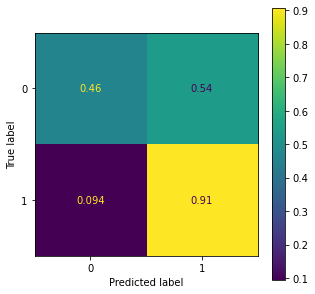

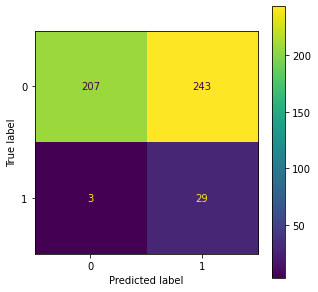

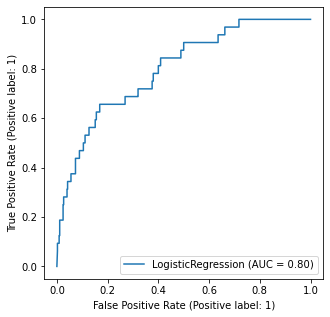

In [52]:
print("Precision score : ",precision_score(y_test,y_pred))
print("Recall score : ",recall_score(y_test,y_pred))
print("F1 score : ",f1_score(y_test,y_pred))

#setting the plot size
plt.rcParams['figure.figsize'] = [5, 5]

#plotting the confusion matrix
plot_confusion_matrix(logist_pca,X_test_num_pca,y_test,normalize = "true")
plot_confusion_matrix(logist_pca,X_test_num_pca,y_test)

#plotting ROC_curve
plot_roc_curve(logist_pca,X_test_num_pca,y_test)


- The recall score improved drastically, but the precision score also decreased. The model is trying to predict many more text examples as class 1, which is the reason for these changes. 
- Consider PCA is based on linear transformations, it might not be correct for our problem. 
- The AUC improved to 0.80
- Next, we try to implement other models for this problem


# Classification Models with selected features
- In this section we use the insights from Feature selection to build a subset of features for training and testing
- We evaluate the performance by using different classification algorithms

## Selecting the Features
- We have 4 different data frames on the feature importance
    - importance_rf_df = Random Forests importance
    - df_lasso_feat = Coefficients of features from Logistic regression with L1
    - ig_rank_df = importances based on information gain
    - corr_bankrupt = pearson correlations of target variable
- Using these four datasets we will try to construct a subset of importance features

In [53]:
#sorting values for the df
importance_rf_df = importance_rf_df.sort_values("Importance",ascending = False)
df_lasso_feat = df_lasso_feat.sort_values("Lasso_score",ascending = False)
ig_ranks_df = ig_ranks_df.sort_values("Score",ascending = False)
corr_bankrupt_df = corr_bankrupt_df.sort_values("Correlation",ascending = False)

In [54]:
#creating feature arrays
ar1 = np.array(importance_rf_df["Features"].iloc[:10])
ar2 = np.array(df_lasso_feat["Features"].iloc[:10])
ar3 = np.array(ig_ranks_df.index[:10])
ar4 = np.array(corr_bankrupt_df.index[:10])

In [55]:
#creating a common master feature array
ar_feat_master = np.concatenate((ar1,ar2,ar3,ar4))
ar_feat_master = np.unique(ar_feat_master)

In [56]:
#converting to a list for easy iteration
ar_feat_master = list(ar_feat_master)
#removing Bankrupt as it is our target
ar_feat_master = ar_feat_master[1:]

In [57]:
print("Selected Features for training :", ar_feat_master)

Selected Features for training : ['X1', 'X10', 'X15', 'X16', 'X2', 'X22', 'X25', 'X26', 'X27', 'X29', 'X3', 'X35', 'X38', 'X39', 'X41', 'X42', 'X48', 'X49', 'X51', 'X55', 'X56', 'X58', 'X6', 'X9']


- Now we use these 24 features as our features data set

## SVM Classifier
- Now we use these selected features in SVC model 

In [58]:
#selecting and renaming for convinience
X_train_select = data_num[ar_feat_master]
X_test_select = X_test_num[ar_feat_master]

print("Shape of Training features Data Set :", X_train_select.shape)
print("Shape of Testing features  Data Set :", X_test_select.shape)
print("Shape of Training target Data Set :", y_train.shape)
print("Shape of Testing target  Data Set :", y_test.shape)


Shape of Training features Data Set : (8120, 24)
Shape of Testing features  Data Set : (482, 24)
Shape of Training target Data Set : (8120,)
Shape of Testing target  Data Set : (482,)


In [59]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

#standard scaler object
scaler = StandardScaler()

#classifier data
clf = SVC()
name = clf.__class__.__name__

#pipeline object
model_pipeline = Pipeline([("scaler",scaler),(name,clf)])

#fitting the pipeline
model_pipeline.fit(X_train_select,y_train)

#in sample score
score_in_sample = model_pipeline.score(X_train_select,y_train)
print("Model: {m:s} in sample score={s:3.2f}\n".format(m=name, s=score_in_sample))

#cross validation 
k = 5
cross_val_scores = cross_val_score(model_pipeline.named_steps[name],X_train_select,y_train,cv=k)
print("Model: {m:s} avg cross validation score={s:3.2f}\n".format(m=name, s=cross_val_scores.mean()) )

#out of sample score
score_out_of_sample = None
score_out_of_sample = model_pipeline.score(X_test_select,y_test)
print("Model: {m:s} out-of-sample score={s:3.2f}\n".format(m=name, s=score_out_of_sample))


Pipeline(steps=[('scaler', StandardScaler()), ('SVC', SVC())])

Model: SVC in sample score=0.79

Model: SVC avg cross validation score=0.79

Model: SVC out-of-sample score=0.60



- In terms of accuracy SVC performs similar to logistic regression with all features
- the out of sample score is lower than in-sample as expected
- Let's look at other performance metrics

In [60]:
#predicting the out of sample labels
y_pred = model_pipeline.predict(X_test_select)

Precision score :  0.10837438423645321
Recall score :  0.6875
F1 score :  0.1872340425531915


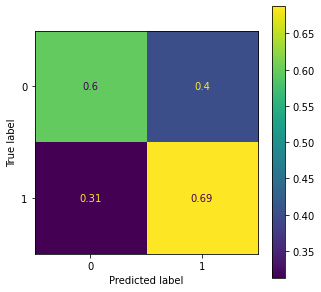

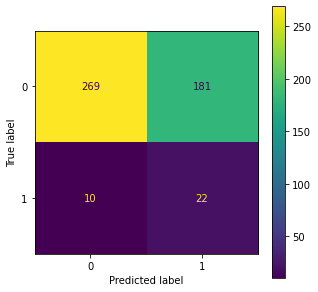

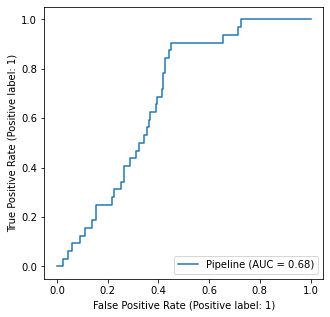

In [61]:
print("Precision score : ",precision_score(y_test,y_pred))
print("Recall score : ",recall_score(y_test,y_pred))
print("F1 score : ",f1_score(y_test,y_pred))

#setting the plot size
plt.rcParams['figure.figsize'] = [5, 5]

#plotting the confusion matrix
plot_confusion_matrix(model_pipeline,X_test_select,y_test,normalize = "true")
plot_confusion_matrix(model_pipeline,X_test_select,y_test)

#plotting ROC_curve
plot_roc_curve(model_pipeline,X_test_select,y_test)


- Even with the selected features our SVC model still has very low precision
- Maybe over sampling by SMOTE is causing the model to misclassify class-0 examples

## Random Forests
- In a test run, when I ran the random_forests model on un balanced data the class the model was not able to categorize any examples as class-1, i.e., the precision and recall were 0
- So we continue to use the balanced data set

In [62]:
#test and train data sets
X_train_select = data_num[ar_feat_master]
X_test_select = X_test_num[ar_feat_master]

print("Shape of Training features Data Set :", X_train_select.shape)
print("Shape of Testing features  Data Set :", X_test_select.shape)
print("Shape of Training target Data Set :", y_train.shape)
print("Shape of Testing target  Data Set :", y_test.shape)

Shape of Training features Data Set : (8120, 24)
Shape of Testing features  Data Set : (482, 24)
Shape of Training target Data Set : (8120,)
Shape of Testing target  Data Set : (482,)


In [63]:
from sklearn.ensemble import RandomForestClassifier

#standard scaler object
scaler = StandardScaler()

#classifier data with parameter for balancing the weights
clf = RandomForestClassifier(random_state=42)
name = clf.__class__.__name__

#pipeline object
model_pipeline = Pipeline([("scaler",scaler),(name,clf)])

#fitting the pipeline
model_pipeline.fit(X_train_select,y_train)

#in sample score
score_in_sample = model_pipeline.score(X_train_select,y_train)
print("Model: {m:s} in sample score={s:3.2f}\n".format(m=name, s=score_in_sample))

#cross validation 
k = 5
cross_val_scores = cross_val_score(model_pipeline.named_steps[name],X_train_select,y_train,cv=k)
print("Model: {m:s} avg cross validation score={s:3.2f}\n".format(m=name, s=cross_val_scores.mean()) )

#out of sample score
score_out_of_sample = None
score_out_of_sample = model_pipeline.score(X_test_select,y_test)
print("Model: {m:s} out-of-sample score={s:3.2f}\n".format(m=name, s=score_out_of_sample))


Pipeline(steps=[('scaler', StandardScaler()),
                ('RandomForestClassifier',
                 RandomForestClassifier(random_state=42))])

Model: RandomForestClassifier in sample score=1.00

Model: RandomForestClassifier avg cross validation score=0.95

Model: RandomForestClassifier out-of-sample score=0.55



- The scores for RandomForests look very promising
- Lets look at the other metrics to evaluate the performance

In [64]:
#predicting the out of sample labels
y_pred = model_pipeline.predict(X_test_select)

Precision score :  0.08444444444444445
Recall score :  0.59375
F1 score :  0.14785992217898833


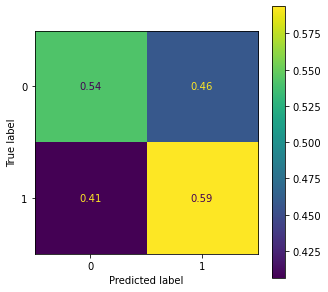

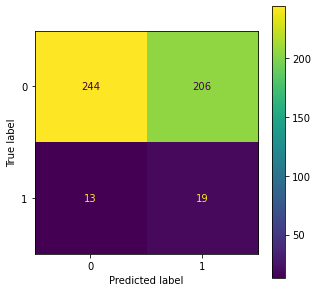

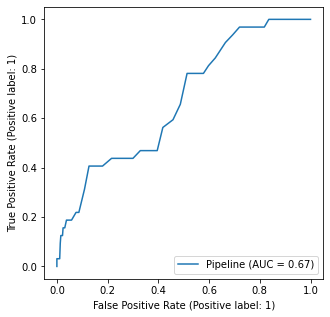

In [65]:
print("Precision score : ",precision_score(y_test,y_pred))
print("Recall score : ",recall_score(y_test,y_pred))
print("F1 score : ",f1_score(y_test,y_pred))

#setting the plot size
plt.rcParams['figure.figsize'] = [5, 5]

#plotting the confusion matrix
plot_confusion_matrix(model_pipeline,X_test_select,y_test,normalize = "true")
plot_confusion_matrix(model_pipeline,X_test_select,y_test)

#plotting ROC_curve
plot_roc_curve(model_pipeline,X_test_select,y_test)

- We can see that the selected features were not able to improve the accuracy
- Maybe we can try using all the features and improve the model using hyper parameter tuning
- Also the default no. of estimators here is 100. But with 63 features this might be a smaller number

# Hyper paramter tuning for a model with all features
- In this section we consider all the features and search the best parameters for a classifier using GridSearchCV

## Logistic Regression hypertuning using GridSearchCV

In [66]:
X_train_cv = data_num
X_test_cv = X_test_num

print("Shape of Training features Data Set :", X_train_cv.shape)
print("Shape of Testing features  Data Set :", X_test_cv.shape)
print("Shape of Training target Data Set :", y_train.shape)
print("Shape of Testing target  Data Set :", y_test.shape)

Shape of Training features Data Set : (8120, 63)
Shape of Testing features  Data Set : (482, 63)
Shape of Training target Data Set : (8120,)
Shape of Testing target  Data Set : (482,)


In [67]:
from sklearn.model_selection import GridSearchCV

#classifier data
clf = LogisticRegression(class_weight = "balanced",solver = "liblinear")

#new scaler
scaler_cv = StandardScaler()

#new pipeline
model_pipeline_cv = Pipeline([("scaling",scaler_cv),("Logist_all",clf)])

param_grid = [{"C" : [0.001, 0.01, 0.1, 1, 10, 100, 1000]}]

clf_grid = GridSearchCV(clf, param_grid = param_grid, cv = 5)

#fitting the data on best set of parameters
best_clf = clf_grid.fit(X_train_cv, y_train)

print("best accuracy from GridSearchCV in sample: ", best_clf.best_score_)
print("Out Sample score from GridSearchCV :", best_clf.score(X_train_cv,y_train))

C:\Users\Santosh\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Santosh\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Santosh\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Santosh\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Santosh\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of 

best accuracy from GridSearchCV in sample:  0.808128078817734
Out Sample score from GridSearchCV : 0.8092364532019705


C:\Users\Santosh\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [68]:
best_clf.best_params_

{'C': 1000}

In [69]:
y_pred = best_clf.predict(X_test_cv)

Precision score :  0.1087866108786611
Recall score :  0.8125
F1 score :  0.1918819188191882


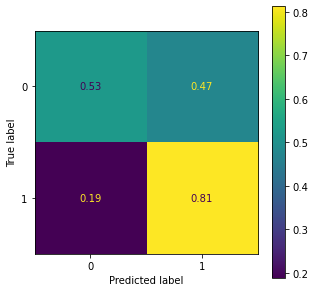

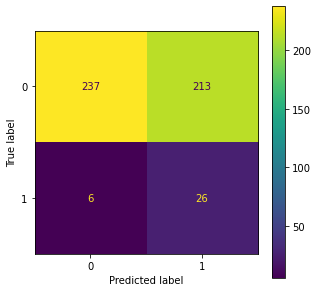

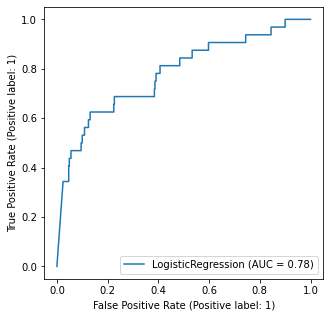

In [70]:
print("Precision score : ",precision_score(y_test,y_pred))
print("Recall score : ",recall_score(y_test,y_pred))
print("F1 score : ",f1_score(y_test,y_pred))

#setting the plot size
plt.rcParams['figure.figsize'] = [5, 5]

#plotting the confusion matrix
plot_confusion_matrix(clf_grid.best_estimator_,X_test_cv,y_test,normalize = "true")
plot_confusion_matrix(clf_grid.best_estimator_,X_test_cv,y_test)

#plotting ROC_curve
plot_roc_curve(clf_grid.best_estimator_,X_test_cv,y_test)

## Random Forests with all features
- In this model we use imputed data from SMOTE. the split between classes is around 50:50
- The number of estimators is increased to 1000 as the feature size is large (64). This gives the random forests enough estimators to learn the patterns
- We use all features for this estimation

In [144]:
X_train = data_num ##imputed with SMOTE (50:50)

print("Shape of Training features Data Set :", X_train.shape)
print("Shape of Testing features  Data Set :", X_test.shape)
print("Shape of Training target Data Set :", y_train.shape)
print("Shape of Testing target  Data Set :", y_test.shape)

Shape of Training features Data Set : (8120, 63)
Shape of Testing features  Data Set : (482, 63)
Shape of Training target Data Set : (8120,)
Shape of Testing target  Data Set : (482,)


In [145]:
from sklearn.ensemble import RandomForestClassifier

#standard scaler object
scaler = StandardScaler()

#classifier data with parameter for balancing the weights
clf = RandomForestClassifier(n_estimators = 1000, class_weight ="balanced",random_state=51)
name = clf.__class__.__name__

#pipeline object
model_pipeline = Pipeline([("scaler",scaler),(name,clf)])

#fitting the pipeline
model_pipeline.fit(X_train,y_train)

#in sample score
score_in_sample = model_pipeline.score(X_train,y_train)
print("Model: {m:s} in sample score={s:3.2f}\n".format(m=name, s=score_in_sample))

#cross validation 
k = 5
cross_val_scores = cross_val_score(model_pipeline.named_steps[name],X_train,y_train,cv=k)
print("Model: {m:s} avg cross validation score={s:3.2f}\n".format(m=name, s=cross_val_scores.mean()) )

#out of sample score
score_out_of_sample = None
score_out_of_sample = model_pipeline.score(X_test,y_test)
print("Model: {m:s} out-of-sample score={s:3.2f}\n".format(m=name, s=score_out_of_sample))


Pipeline(steps=[('scaler', StandardScaler()),
                ('RandomForestClassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=51))])

Model: RandomForestClassifier in sample score=1.00

Model: RandomForestClassifier avg cross validation score=0.96

Model: RandomForestClassifier out-of-sample score=0.77



In [146]:
y_pred = model_pipeline.predict(X_test)

Precision score :  0.024390243902439025
Recall score :  0.0625
F1 score :  0.03508771929824562


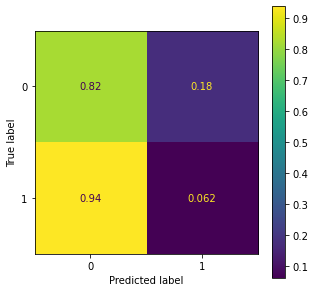

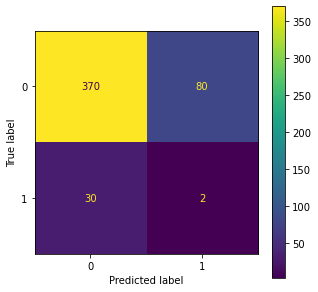

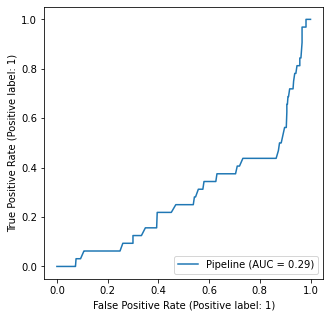

In [147]:
#predicting the out of sample labels
y_pred = model_pipeline.predict(X_test)

print("Precision score : ",precision_score(y_test,y_pred))
print("Recall score : ",recall_score(y_test,y_pred))
print("F1 score : ",f1_score(y_test,y_pred))

#setting the plot size
plt.rcParams['figure.figsize'] = [5, 5]

#plotting the confusion matrix
plot_confusion_matrix(model_pipeline,X_test,y_test,normalize = "true")
plot_confusion_matrix(model_pipeline,X_test,y_test)

#plotting ROC_curve
plot_roc_curve(model_pipeline,X_test,y_test)

# Changing Class imbalance
- the precision values are extremely low for some of our models. So instead of oversampling the minority class to 50%, this time we restrict our values to a ratio
- In this section we use SVM as our base to investigate this further

## SVC with 4/7 as sampling strategy ratio

In [148]:
#minority to majority sample ratio is set as 4/7
from imblearn.over_sampling import SMOTE
SM = SMOTE(sampling_strategy=4/7, k_neighbors=5, random_state=42)
data_num_new, y_train_new = SM.fit_resample(data_num_unb, y_train_unb)

In [149]:
#selecting and renaming for convinience
X_train = data_num_new
y_train = y_train_new

print("Shape of Training features Data Set :", X_train.shape)
print("Shape of Testing features  Data Set :", X_test.shape)
print("Shape of Training target Data Set :", y_train.shape)
print("Shape of Testing target  Data Set :", y_test.shape)

Shape of Training features Data Set : (6380, 63)
Shape of Testing features  Data Set : (482, 63)
Shape of Training target Data Set : (6380,)
Shape of Testing target  Data Set : (482,)


In [150]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

#standard scaler object
scaler = StandardScaler()

#classifier data
clf = SVC()
name = clf.__class__.__name__

#pipeline object
model_pipeline = Pipeline([("scaler",scaler),(name,clf)])

#fitting the pipeline
model_pipeline.fit(X_train,y_train)

#in sample score
score_in_sample = model_pipeline.score(X_train,y_train)
print("Model: {m:s} in sample score={s:3.2f}\n".format(m=name, s=score_in_sample))

#cross validation 
k = 5
cross_val_scores = cross_val_score(model_pipeline.named_steps[name],X_train,y_train,cv=k)
print("Model: {m:s} avg cross validation score={s:3.2f}\n".format(m=name, s=cross_val_scores.mean()) )

#out of sample score
score_out_of_sample = None
score_out_of_sample = model_pipeline.score(X_test,y_test)
print("Model: {m:s} out-of-sample score={s:3.2f}\n".format(m=name, s=score_out_of_sample))

Pipeline(steps=[('scaler', StandardScaler()), ('SVC', SVC())])

Model: SVC in sample score=0.80

Model: SVC avg cross validation score=0.65

Model: SVC out-of-sample score=0.89



Precision score :  0.3275862068965517
Recall score :  0.59375
F1 score :  0.42222222222222217


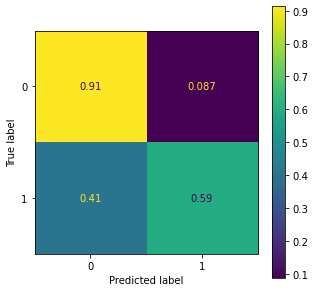

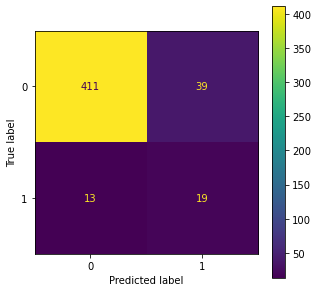

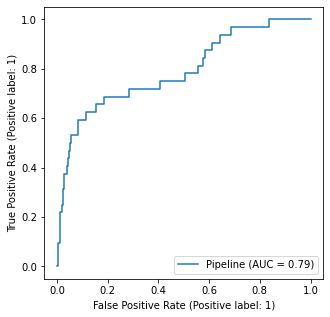

In [151]:
#predicting the out of sample labels
y_pred = model_pipeline.predict(X_test)

print("Precision score : ",precision_score(y_test,y_pred))
print("Recall score : ",recall_score(y_test,y_pred))
print("F1 score : ",f1_score(y_test,y_pred))

#setting the plot size
plt.rcParams['figure.figsize'] = [5, 5]

#plotting the confusion matrix
plot_confusion_matrix(model_pipeline,X_test,y_test,normalize = "true")
plot_confusion_matrix(model_pipeline,X_test,y_test)

#plotting ROC_curve
plot_roc_curve(model_pipeline,X_test,y_test)

- The metrics have definetely improved from using "auto" SMOTE
- Reducing the size of class-1 samples helped improve the precision and overall F1 score
- Random Forests with all features performed better

## Exploring different sampling strategy ratios using Logistic regression 
- In this section we iterate through multiple values of sampling strategy ratios
- The values of precision, recall and other metrics have been stored in data frames for analysis purpose

In [ ]:
score_in ={}
score_out ={}
score_cross ={}
score_recall = {}
score_precision = {}
score_f1 = {}

##1/9,2/8, 3/7, 4/6

for i in [0.1,0.2,0.25,0.3,0.35,0.40,0.45]: ##weights for SMOTE imputation

    SM = SMOTE(sampling_strategy= i, k_neighbors=5, random_state=42)
    data_num_new, y_train_new = SM.fit_resample(data_num_unb, y_train_unb)
    
    #selecting and renaming for convinience
    X_train = data_num_new
    y_train = y_train_new
    
    #scaler
    scaler = StandardScaler()
    
    #logistic regression | changing max_iter = 500 for better chance of convergence
    clf = LogisticRegression(max_iter=500, random_state = 42)
    
    #pipeline
    model_pipeline = Pipeline([("scaling",scaler),("Logist_all",clf)])
    
    #fitting the pipeline
    model_pipeline.fit(X_train,y_train)
    
    #predicting the out of sample labels
    y_pred = model_pipeline.predict(X_test)
    
    #in sample score
    score_in_sample = model_pipeline.score(X_train,y_train)
    score_in.update({i:score_in_sample})
    
    #cross validation 
    cross_val_scores = cross_val_score(model_pipeline.named_steps["Logist_all"],X_train,y_train,cv=5)
    score_cross.update({i:cross_val_scores.mean()})
    
    #out of sample score
    score_out_of_sample = model_pipeline.score(X_test,y_test)
    score_out.update({i:score_out_of_sample})
    
    #precision
    score_precision.update({i:precision_score(y_test,y_pred)})
    
    #recall
    score_recall.update({i:recall_score(y_test,y_pred)})
    
    #F1 score
    score_f1.update({i:f1_score(y_test,y_pred)})

In [153]:
print("Recall Score with changing class weights",score_recall )
print("Precision Score with changing class weights",score_precision )

Recall Score with changing class weights {0.1: 0.0625, 0.2: 0.28125, 0.25: 0.34375, 0.3: 0.34375, 0.35: 0.40625, 0.4: 0.40625, 0.45: 0.4375}
Precision Score with changing class weights {0.1: 0.25, 0.2: 0.42857142857142855, 0.25: 0.4230769230769231, 0.3: 0.4230769230769231, 0.35: 0.38235294117647056, 0.4: 0.325, 0.45: 0.30434782608695654}


- Looking at the results from our loop above, we can see that recall generally increases as the size of the class 1 examples increase
- As expected precision decreases with increase in class 1 size
- We need to find a trade off between precision and recall

# Experimentation
- In this section we try to combine the features of our best models and imputation techniques

## Random Forests with all features with 4/7 as sampling strategy as ratio

In [154]:
#minority to majority sample ratio is set as 4/7
from imblearn.over_sampling import SMOTE
SM = SMOTE(sampling_strategy=4/7, k_neighbors=5, random_state=42)
data_num_new, y_train_new = SM.fit_resample(data_num_unb, y_train_unb)

In [155]:
#selecting and renaming for convinience
X_train = data_num_new
y_train = y_train_new

print("Shape of Training features Data Set :", X_train.shape)
print("Shape of Testing features  Data Set :", X_test.shape)
print("Shape of Training target Data Set :", y_train.shape)
print("Shape of Testing target  Data Set :", y_test.shape)

Shape of Training features Data Set : (6380, 63)
Shape of Testing features  Data Set : (482, 63)
Shape of Training target Data Set : (6380,)
Shape of Testing target  Data Set : (482,)


In [156]:
#standard scaler object
scaler = StandardScaler()

#classifier data
clf = RandomForestClassifier(n_estimators = 1000, class_weight ="balanced",random_state=42)
name = clf.__class__.__name__

#pipeline object
model_pipeline = Pipeline([("scaler",scaler),(name,clf)])

#fitting the pipeline
model_pipeline.fit(X_train,y_train)

#in sample score
score_in_sample = model_pipeline.score(X_train,y_train)
print("Model: {m:s} in sample score={s:3.2f}\n".format(m=name, s=score_in_sample))

#cross validation 
k = 5
cross_val_scores = cross_val_score(model_pipeline.named_steps[name],X_train,y_train,cv=k)
print("Model: {m:s} avg cross validation score={s:3.2f}\n".format(m=name, s=cross_val_scores.mean()) )

#out of sample score
score_out_of_sample = None
score_out_of_sample = model_pipeline.score(X_test,y_test)
print("Model: {m:s} out-of-sample score={s:3.2f}\n".format(m=name, s=score_out_of_sample))

Pipeline(steps=[('scaler', StandardScaler()),
                ('RandomForestClassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=42))])

Model: RandomForestClassifier in sample score=1.00

Model: RandomForestClassifier avg cross validation score=0.95

Model: RandomForestClassifier out-of-sample score=0.93



Precision score :  0.5
Recall score :  0.46875
F1 score :  0.4838709677419355


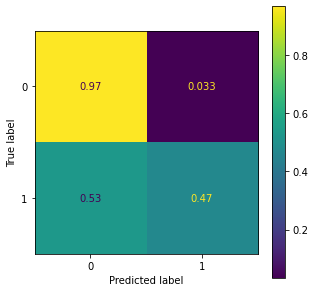

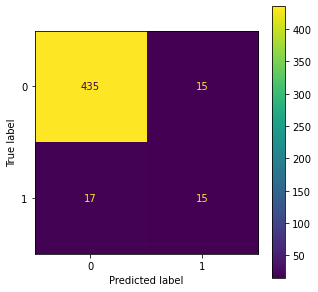

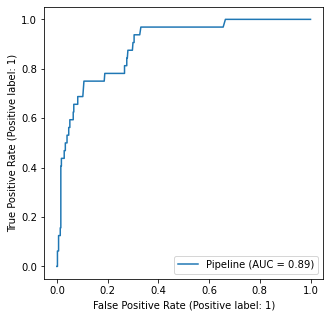

In [158]:
#predicting the out of sample labels
y_pred = model_pipeline.predict(X_test)

print("Precision score : ",precision_score(y_test,y_pred))
print("Recall score : ",recall_score(y_test,y_pred))
print("F1 score : ",f1_score(y_test,y_pred))

#setting the plot size
plt.rcParams['figure.figsize'] = [5, 5]

#plotting the confusion matrix
plot_confusion_matrix(model_pipeline,X_test,y_test,normalize = "true")
plot_confusion_matrix(model_pipeline,X_test,y_test)

#plotting ROC_curve
plot_roc_curve(model_pipeline,X_test,y_test)

- The recall value decreased to 0.47. So reducing the strategy_sample ratio reduced the recall as there are less number of class1 examples to learn from
- In the next experiment we bring back the ratio to 0.5 (balanced classes) but introduce PCA to improve the performance

## Random Forests with balanced classes and PCA

In [159]:
#minority to majority sample ratio is set as auto, i.e, 50:50 for class1:class0
from imblearn.over_sampling import SMOTE
SM = SMOTE(sampling_strategy="auto", k_neighbors=5, random_state=42)
data_num_new, y_train_new = SM.fit_resample(data_num_unb, y_train_unb)

In [160]:
#selecting and renaming for convinience
X_train = data_num_new
y_train = y_train_new

print("Shape of Training features Data Set :", X_train.shape)
print("Shape of Testing features  Data Set :", X_test.shape)
print("Shape of Training target Data Set :", y_train.shape)
print("Shape of Testing target  Data Set :", y_test.shape)

Shape of Training features Data Set : (8120, 63)
Shape of Testing features  Data Set : (482, 63)
Shape of Training target Data Set : (8120,)
Shape of Testing target  Data Set : (482,)


Pipeline(steps=[('scaler', StandardScaler()), ('PCA', PCA(n_components=30)),
                ('RandomForestClassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=42))])

Model: RandomForestClassifier in sample score=1.00

Model: RandomForestClassifier avg cross validation score=0.97

Model: RandomForestClassifier out-of-sample score=0.88

Precision score :  0.2777777777777778
Recall score :  0.46875
F1 score :  0.3488372093023256


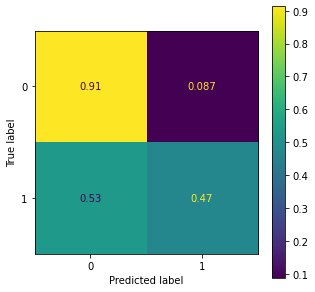

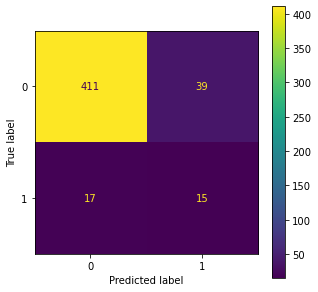

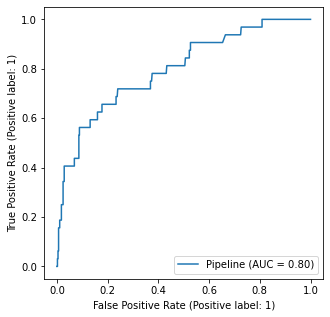

In [161]:
#standard scaler object | necessary for PCA
scaler = StandardScaler()

#PCA model with 30 components | based on 6.6.2
pca_rf = PCA(n_components=30)

#classifier data
clf = RandomForestClassifier(n_estimators = 1000, class_weight ="balanced",random_state=42)
name = clf.__class__.__name__

#pipeline object
model_pipeline = Pipeline([("scaler",scaler),("PCA",pca_rf), (name,clf)])

#fitting the pipeline
model_pipeline.fit(X_train,y_train)

#in sample score
score_in_sample = model_pipeline.score(X_train,y_train)
print("Model: {m:s} in sample score={s:3.2f}\n".format(m=name, s=score_in_sample))

#cross validation 
k = 5
cross_val_scores = cross_val_score(model_pipeline.named_steps[name],X_train,y_train,cv=k)
print("Model: {m:s} avg cross validation score={s:3.2f}\n".format(m=name, s=cross_val_scores.mean()) )

#out of sample score
score_out_of_sample = None
score_out_of_sample = model_pipeline.score(X_test,y_test)
print("Model: {m:s} out-of-sample score={s:3.2f}\n".format(m=name, s=score_out_of_sample))

#predicting the out of sample labels
y_pred = model_pipeline.predict(X_test)

print("Precision score : ",precision_score(y_test,y_pred))
print("Recall score : ",recall_score(y_test,y_pred))
print("F1 score : ",f1_score(y_test,y_pred))

#setting the plot size
plt.rcParams['figure.figsize'] = [5, 5]

#plotting the confusion matrix
plot_confusion_matrix(model_pipeline,X_test,y_test,normalize = "true")
plot_confusion_matrix(model_pipeline,X_test,y_test)

#plotting ROC_curve
plot_roc_curve(model_pipeline,X_test,y_test)

- Using PCA decreased our performance. This might suggest non-linearity in our data set

In [162]:
#standard scaler object | necessary for PCA
scaler = StandardScaler()

#PCA model with 30 components | based on 6.6.2
pca_rf = PCA(n_components=30)

#classifier data
clf = RandomForestClassifier(n_estimators = 1000, class_weight ="balanced",random_state=42)
name = clf.__class__.__name__

#pipeline object
model_pipeline = Pipeline([("scaler",scaler),("PCA",pca_rf), (name,clf)])

#fitting the pipeline
model_pipeline.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('PCA', PCA(n_components=30)),
                ('RandomForestClassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=42))])

## Random Forest Hyper Parameter tuning using Grid Search CV 
- This section of GridSearchCv couldn't run because of high computational requirement. Ideally by running this should help us identify the best set of parameters to be used in Random Forest for our Binary classification problem

In [ ]:
#minority to majority sample ratio is set as auto, i.e, 50:50 for class1:class0
from imblearn.over_sampling import SMOTE
SM = SMOTE(sampling_strategy="auto", k_neighbors=5, random_state=42)
data_num_new, y_train_new = SM.fit_resample(data_num_unb, y_train_unb)

In [ ]:
#selecting and renaming for convinience
X_train = data_num_new
y_train = y_train_new

print("Shape of Training features Data Set :", X_train.shape)
print("Shape of Testing features  Data Set :", X_test.shape)
print("Shape of Training target Data Set :", y_train.shape)
print("Shape of Testing target  Data Set :", y_test.shape)

In [ ]:
from sklearn.metrics import f1_score

#classifier data
clf = RandomForestClassifier(class_weight ="balanced",random_state=42)

#parameters
n_estimators = [300, 500, 800, 1200, 1400] ##no of estimators, default is 100
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

params = dict(n_estimators = n_estimators, max_depth = max_depth,min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

#using f1 score as the metric to improve
clf_grid = GridSearchCV(clf, param_grid = [params], cv = 5)

#fitting the data on best set of parameters
best_clf = clf_grid.fit(X_train, y_train)

print("best accuracy from GridSearchCV in sample: ", best_clf.best_score_)
print("Out Sample score from GridSearchCV :", best_clf.score(X_train,y_train))

print("Best parameters : ", best_clf.best_params_)

In [ ]:
y_pred = best_clf.predict(X_test_cv)

print("Precision score : ",precision_score(y_test,y_pred))
print("Recall score : ",recall_score(y_test,y_pred))
print("F1 score : ",f1_score(y_test,y_pred))

#setting the plot size
plt.rcParams['figure.figsize'] = [5, 5]

#plotting the confusion matrix
plot_confusion_matrix(clf_grid.best_estimator_,X_test_cv,y_test,normalize = "true")
plot_confusion_matrix(clf_grid.best_estimator_,X_test_cv,y_test)

#plotting ROC_curve
plot_roc_curve(clf_grid.best_estimator_,X_test_cv,y_test)

## Boosting - XGboost
What we learnt so far
- From our analysis we identified that PCA is not helpful in our classification problem
- Changes in Strategy sample ratio causes huge fluctuation in the precision and recall
- But with a balanced data set Random Forest is our best estimator so far

Nowe we explore Boosting algorithm XG Boost to check if we can improve our performance

In [164]:
#minority to majority sample ratio set to auto
from imblearn.over_sampling import SMOTE
SM = SMOTE(sampling_strategy="auto", k_neighbors=5, random_state=42)
data_num_new, y_train_new = SM.fit_resample(data_num_unb, y_train_unb)

#selecting and renaming for convinience
X_train = data_num_new
y_train = y_train_new

print("Shape of Training features Data Set :", X_train.shape)
print("Shape of Testing features  Data Set :", X_test.shape)
print("Shape of Training target Data Set :", y_train.shape)
print("Shape of Testing target  Data Set :", y_test.shape)

Shape of Training features Data Set : (8120, 63)
Shape of Testing features  Data Set : (482, 63)
Shape of Training target Data Set : (8120,)
Shape of Testing target  Data Set : (482,)


[17:50:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('scaler', StandardScaler()),
                ('XGBClassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               use_label_encoder=False, validate_parameters=1,
                               verbosity=None))])

Model: XGBClassifier in sample score=1.00

[17:50:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:42] WARNING: C:/User

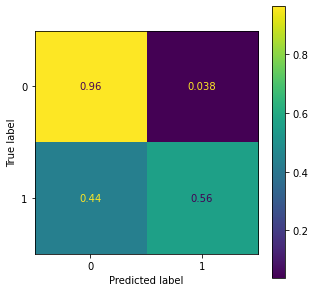

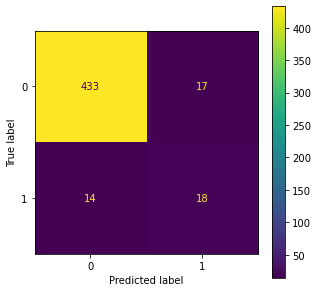

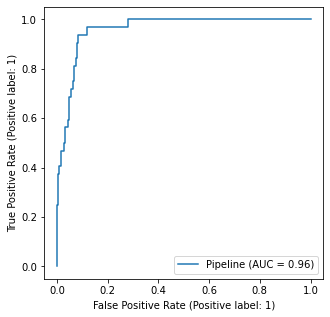

In [165]:
from xgboost import XGBClassifier


#standard scaler object 
scaler = StandardScaler()

#classifier data
# passing use_label_encoder = false to avoid deprication warnings. Our labels are already encoded as 0 or 1
clf = XGBClassifier(random_state=42,use_label_encoder=False)
name = clf.__class__.__name__

#pipeline object
model_pipeline = Pipeline([("scaler",scaler),(name,clf)])

#fitting the pipeline
model_pipeline.fit(X_train,y_train)

#in sample score
score_in_sample = model_pipeline.score(X_train,y_train)
print("Model: {m:s} in sample score={s:3.2f}\n".format(m=name, s=score_in_sample))

#cross validation 
k = 5
cross_val_scores = cross_val_score(model_pipeline.named_steps[name],X_train,y_train,cv=k)
print("Model: {m:s} avg cross validation score={s:3.2f}\n".format(m=name, s=cross_val_scores.mean()) )

#out of sample score
score_out_of_sample = None
score_out_of_sample = model_pipeline.score(X_test,y_test)
print("Model: {m:s} out-of-sample score={s:3.2f}\n".format(m=name, s=score_out_of_sample))

#predicting the out of sample labels
y_pred = model_pipeline.predict(X_test)

print("Precision score : ",precision_score(y_test,y_pred))
print("Recall score : ",recall_score(y_test,y_pred))
print("F1 score : ",f1_score(y_test,y_pred))

#setting the plot size
plt.rcParams['figure.figsize'] = [5, 5]

#plotting the confusion matrix
plot_confusion_matrix(model_pipeline,X_test,y_test,normalize = "true")
plot_confusion_matrix(model_pipeline,X_test,y_test)

#plotting ROC_curve
plot_roc_curve(model_pipeline,X_test,y_test)

- We can see that XGboost actually improved our performance.
- The F1 score reached 0.53 which was better than Random Forests

#### XGboost with Adasyn
- With 50:50 ratio between class1 and class 0 examples we were able to acheive a recall of 0.55
- Identifying companies with possibility of Bankruptcy is important for investors. So lets see if we can improve recall by using Adasyn imputer. Considering Adasyn includes some randomness the data set will be close to relaity
- Ideally we should increase the minority class 1 to the majority class for better recall. But SMOTE strategy sampling ratio has a maximum value of 1. Hence using a different imputer to improve the performances

In [166]:
from imblearn.over_sampling import ADASYN
ad = ADASYN(random_state=42)
data_num_new, y_train_new = ad.fit_resample(data_num_unb, y_train_unb)

#selecting and renaming for convinience
X_train = data_num_new
y_train = y_train_new

print("Shape of Training features Data Set :", X_train.shape)
print("Shape of Testing features  Data Set :", X_test.shape)
print("Shape of Training target Data Set :", y_train.shape)
print("Shape of Testing target  Data Set :", y_test.shape)

Shape of Training features Data Set : (8155, 63)
Shape of Testing features  Data Set : (482, 63)
Shape of Training target Data Set : (8155,)
Shape of Testing target  Data Set : (482,)


[17:54:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('scaler', StandardScaler()),
                ('XGBClassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               use_label_encoder=False, validate_parameters=1,
                               verbosity=None))])

Model: XGBClassifier in sample score=1.00

[17:55:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:55:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:55:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:55:20] WARNING: C:/User

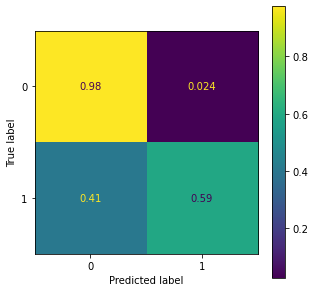

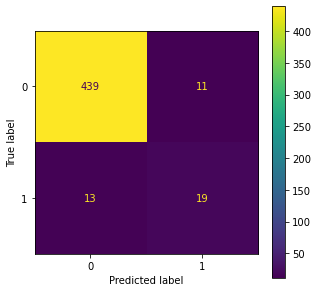

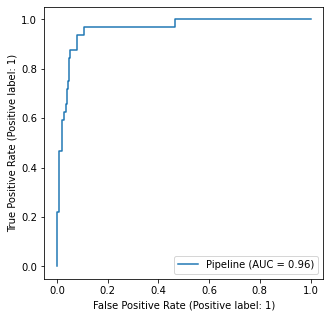

In [167]:
#standard scaler object 
scaler = StandardScaler()

#classifier data
# passing use_label_encoder = false to avoid deprication warnings. Our labels are already encoded as 0 or 1
clf = XGBClassifier(random_state=42,use_label_encoder=False)
name = clf.__class__.__name__

#pipeline object
model_pipeline = Pipeline([("scaler",scaler),(name,clf)])

#fitting the pipeline
model_pipeline.fit(X_train,y_train)

#in sample score
score_in_sample = model_pipeline.score(X_train,y_train)
print("Model: {m:s} in sample score={s:3.2f}\n".format(m=name, s=score_in_sample))

#cross validation 
k = 5
cross_val_scores = cross_val_score(model_pipeline.named_steps[name],X_train,y_train,cv=k)
print("Model: {m:s} avg cross validation score={s:3.2f}\n".format(m=name, s=cross_val_scores.mean()) )

#out of sample score
score_out_of_sample = None
score_out_of_sample = model_pipeline.score(X_test,y_test)
print("Model: {m:s} out-of-sample score={s:3.2f}\n".format(m=name, s=score_out_of_sample))

#predicting the out of sample labels
y_pred = model_pipeline.predict(X_test)

print("Precision score : ",precision_score(y_test,y_pred))
print("Recall score : ",recall_score(y_test,y_pred))
print("F1 score : ",f1_score(y_test,y_pred))

#setting the plot size
plt.rcParams['figure.figsize'] = [5, 5]

#plotting the confusion matrix
plot_confusion_matrix(model_pipeline,X_test,y_test,normalize = "true")
plot_confusion_matrix(model_pipeline,X_test,y_test)

#plotting ROC_curve
plot_roc_curve(model_pipeline,X_test,y_test)

- We can see that the XGboost Model with Adasyn imputer was able to increase both precision and recall
- The high AUC score is indicative of better performance
- We would use these techniques to build the MyModel Function

### Predictor for MyModel function
- here we run the model again with a unique name this time to avoid confusion for the MyModel function


In [ ]:
from imblearn.over_sampling import ADASYN
ad = ADASYN(random_state=42)
data_num_new, y_train_new = ad.fit_resample(data_num_unb, y_train_unb)

#selecting and renaming for convinience
X_train = data_num_new
y_train = y_train_new

print("Shape of Training features Data Set :", X_train.shape)
print("Shape of Testing features  Data Set :", X_test.shape)
print("Shape of Training target Data Set :", y_train.shape)
print("Shape of Testing target  Data Set :", y_test.shape)

#standard scaler object 
scaler = StandardScaler()

#classifier data
# passing use_label_encoder = false to avoid deprication warnings. Our labels are already encoded as 0 or 1
clf = XGBClassifier(random_state=42,use_label_encoder=False)
name = clf.__class__.__name__

#pipeline object
model_pipeline_MyModel = Pipeline([("scaler",scaler),(name,clf)])

#fitting the pipeline
model_pipeline_MyModel.fit(X_train,y_train)

#in sample score
score_in_sample = model_pipeline_MyModel.score(X_train,y_train)
print("Model: {m:s} in sample score={s:3.2f}\n".format(m=name, s=score_in_sample))

#cross validation 
k = 5
cross_val_scores = cross_val_score(model_pipeline_MyModel.named_steps[name],X_train,y_train,cv=k)
print("Model: {m:s} avg cross validation score={s:3.2f}\n".format(m=name, s=cross_val_scores.mean()) )

#out of sample score
score_out_of_sample = None
score_out_of_sample = model_pipeline_MyModel.score(X_test,y_test)
print("Model: {m:s} out-of-sample score={s:3.2f}\n".format(m=name, s=score_out_of_sample))

#predicting the out of sample labels
y_pred = model_pipeline_MyModel.predict(X_test)

print("Precision score : ",precision_score(y_test,y_pred))
print("Recall score : ",recall_score(y_test,y_pred))
print("F1 score : ",f1_score(y_test,y_pred))

#setting the plot size
plt.rcParams['figure.figsize'] = [5, 5]

#plotting the confusion matrix
plot_confusion_matrix(model_pipeline_MyModel,X_test,y_test,normalize = "true")
plot_confusion_matrix(model_pipeline_MyModel,X_test,y_test)

#plotting ROC_curve
plot_roc_curve(model_pipeline_MyModel,X_test,y_test)

## MyModel Function

Data Preperation
- Convert to numeric values
- Drop columns X37 (multiple missing values) and Id (arbitrary serial no.)
- Use KNN imputer to fill missing values
- Scale the data using Standard Scaler

Classifier
- Use XGBoost classifier for predictions




In [ ]:
def MyModel(df_test):
    '''
    Returns the predicted values, performs imputation on the test data set
    
    Parameters
    -----------
    df_test : Testing DataFrame
    
    '''
    ##data preperation
    
    ##correcting test data set for storing test/holdout vales
    X_test_new = pd.DataFrame()
    ##running through a loop to convert objects to numeric
    for i in X_test.columns:
        X_test_new[i] = pd.to_numeric(df_test[i], errors = "coerce")
    
    ## removing X37 and Id columns
    X_test_new = X_test_new.drop(columns = ["X37","Id"])
    
    #imputing test data. We are using the same imputer to transform test data
    X_test_new = pd.DataFrame(imputer.transform(X_test_new),columns = X_test_new.columns)
    
    #predicting the out of sample labels
    y_pred = model_pipeline_MyModel.predict(X_test_new)
    
    #returning predictions
    return y_pred 

## Conclusion and Comments
**Background**: It is very important to predict bankruptcy of company. In our classification problem we try to do that using several financial ratios

**Methodology:**
- The data provided has to be cleaned. It has missing values and redudant columns like ID. 
- The values of the financial ratios in some columns is non-numeric. We converted them to numeric data and imputed the missing values using KNNImputer
- The data suffers from class imbalance. This has been corrected using SMOTE and ADASYN imputers
- The strategic sample ratio (minority_count/majority_count) is key in achieving precision-recall trade off. Higher class1 samples, higher the recall
- We used Logistic Regression, SVC, Random Forest and XG boost for our prediction
- Ensemble methods - RandomForests and XGboost has better performance than standalone models
- To reduce dimensionality we used PCA. But found that PCA actually decreases the performance. This suggests non-linearity in the data set
- We used different Feature importance techniques and EDA to find out the most important fields for prediction. But this did not help our classification problem. Hence we continued to use all the features except X37 and Id

**Goal** : Even though its important to predict the bankrupt companies, false predictions might have a significant impact on the position we might take in a company. So here we try to acheive a balance between them. 

- We can easily tweak our problem to acheive better recall by making class-1 majority class. In order to increase precision we need to keep class-0 as the majority class
- Consider our Goal is a tradeoff giving equal imporatnce to both, we used a 50:50 split in our final model

**Results and Conclusion** :
- We were able to acheive around 63% precision and 60% recall through an XGboostClassifier with Adasyn imputation
- In order to improve this we need to perform heavy computational GridSearchCV on selecting the best parameters
- XGboostClassifier gives us better results and runs faster due to Stochastic gradient boosting
- Considering ours is a sequential learning model, we can expect to learn the patterns better